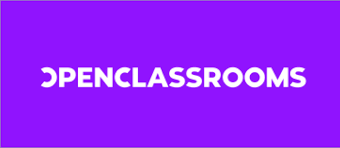
<h1><center> Projet 08 : Participez à une compétition Kaggle ! </center></h1>
<h2><center> Notebook</center></h2>
<h2><center> Parcours Ingénieur machine learning </center></h2>
<h3><center> E. Vezzoli </center></h3>
<h3><center> 11/2019 </center></h3>

# Preparation de l'environnement

In [0]:
#@title Import des librairies
import os
import glob
import shutil
from zipfile import ZipFile 

import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from math import sin, cos
import seaborn as sns
from PIL import Image, ImageOps

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import math


from keras.utils import to_categorical

from keras import optimizers
import keras.callbacks as callbacks

from keras.utils import multi_gpu_model

import imp

import tensorflow as tf

from keras import layers, initializers, regularizers, constraints
from keras.utils import conv_utils
from keras.layers import InputSpec
from keras.utils.conv_utils import conv_output_length

from keras import models
from keras.layers import Layer
from keras.layers import Input, Conv2D, Activation, Lambda, Reshape, Concatenate
from keras.layers import BatchNormalization, Conv1D, Deconvolution2D, Conv2DTranspose
from keras.callbacks import Callback, TensorBoard
from keras.utils import plot_model
from keras.layers.convolutional import UpSampling2D


Using TensorFlow backend.


In [0]:
#@title Téléchargement des données
#@markdown On télécharge les données pour la compétition

Kaggle_username = "evezzoli" #@param {type:"string"}
Kaggle_key = "ff67ecd62784ca247c34335615fd77b3" #@param {type:"string"}


os.environ['KAGGLE_USERNAME'] = Kaggle_username
os.environ['KAGGLE_KEY'] = Kaggle_key
!kaggle competitions download -c pku-autonomous-driving # api copied from kaggle

  0% 0.00/6.75M [00:00<?, ?B/s]
100% 6.75M/6.75M [00:00<00:00, 62.0MB/s]
  0% 0.00/80.9k [00:00<?, ?B/s]
100% 80.9k/80.9k [00:00<00:00, 91.7MB/s]
  0% 0.00/1.11M [00:00<?, ?B/s]
100% 1.11M/1.11M [00:00<00:00, 163MB/s]
  0% 0.00/193 [00:00<?, ?B/s]
100% 193/193 [00:00<00:00, 201kB/s]
 89% 7.00M/7.90M [00:00<00:00, 70.2MB/s]
100% 7.90M/7.90M [00:00<00:00, 72.8MB/s]
100% 1.60G/1.60G [00:23<00:00, 79.1MB/s]
100% 1.60G/1.60G [00:23<00:00, 72.2MB/s]
 99% 498M/503M [00:10<00:00, 48.2MB/s]
100% 503M/503M [00:10<00:00, 50.6MB/s]
100% 2.83G/2.83G [00:50<00:00, 56.2MB/s]
100% 2.83G/2.83G [00:50<00:00, 60.5MB/s]
 29% 5.00M/17.2M [00:00<00:01, 10.2MB/s]
100% 17.2M/17.2M [00:00<00:00, 29.4MB/s]


In [0]:
#@title Création des fonctions
#@markdown On crée des fonctions utiles

# Création d'un dossier
def create_repertory(rep):
    """
    fonction de création de dossier
    """
    try:
        os.mkdir(rep)
    except:
        print('Le dossier est existant')

# Affichage d'une image et son histogramme
def print_image(img):
    """
    fonction d'affichage de l'image
    """
    # On affiche l'image
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    # On affiche l'histogramme
    plt.subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=range(256))
    plt.show()

In [0]:
#@title Decompression des données
#@markdown On decompresse les fichiers

# On liste les fichiers
files = glob.glob("/content/*.zip")
# On supprime le dossier
shutil.rmtree('Data', True)
# On créé les dossier de données
create_repertory('Data')
# On stocke le dossier de travail dans la variable path
path = os.getcwd()

# ouvrir les fichiers zip en mode lecture
for file in files:
    with ZipFile(file, 'r') as zip: 
        # afficher tout le contenu du fichier zip
        zip.printdir()
        file = file.split('/content/')[1]
        file = file.split('.zip')[0]
        rep = 'Data/' + file
        # On supprime le dossier
        shutil.rmtree(rep, True)
        # On créé les dossier de données
        create_repertory(rep)
    
        # extraire tous les fichiers
        print('extraction...') 
        zip.extractall(rep) 
        print('Terminé!')

File Name                                             Modified             Size
benchi-ML500.pkl                               2019-04-27 11:49:52       320798
037-CAR02.pkl                                  2019-04-27 11:49:48       362709
baojun-310-2017.pkl                            2019-04-27 11:49:48       314105
bieke.pkl                                      2019-04-27 11:49:54       287783
biyadi-qin.pkl                                 2019-04-27 11:49:54       304896
baoma-530.pkl                                  2019-04-27 11:49:50       308417
biyadi-tang.pkl                                2019-04-27 11:49:56       369313
changcheng-H6-2016.pkl                         2019-04-27 11:49:56       330200
biaozhi-liangxiang.pkl                         2019-04-27 11:49:54       297998
dongfeng-xuetielong-C6.pkl                     2019-04-27 11:50:00       329361
aodi-a6.pkl                                    2019-04-27 11:49:48       295667
dongfeng-yulong-naruijie.pkl            

In [0]:
#@title Lister les dossiers
#@markdown On liste les dossiers


train_img = []
test_img = []
train_masks = []
test_masks = []
car_models_json = []

# On liste le train
files = glob.glob('Data/train_images' + "/*.jpg")
for file in files:
    train_img.append(file)

files = glob.glob('Data/train_masks' + "/*.jpg")
for file in files:
    train_masks.append(file)
# On liste le test
files = glob.glob('Data/test_images' + "/*.jpg")
for file in files:
    test_img.append(file)

files = glob.glob('Data/test_masks' + "/*.jpg")
for file in files:
    test_masks.append(file)

# On liste les json
files = glob.glob('Data/car_models_json' + "/*.json")
for file in files:
    car_models_json.append(file)

In [0]:
#@title Creation des DataFrames
#@markdown On créé des dataframes

# Train_img
train_img_df = pd.DataFrame(train_img, columns= ['train_img'])
train_img_df['ImageId'] = train_img_df['train_img'].str.split('Data/train_images/', expand=True)[1].str.split('.jpg', expand=True)[0]

# Train_masks
train_masks_df = pd.DataFrame(train_masks, columns= ['train_masks'])
train_masks_df['ImageId'] = train_masks_df['train_masks'].str.split('Data/train_masks/', expand=True)[1].str.split('.jpg', expand=True)[0]

# Test_img
test_img_df = pd.DataFrame(test_img, columns= ['test_img'])
test_img_df['ImageId'] = test_img_df['test_img'].str.split('Data/test_images/', expand=True)[1].str.split('.jpg', expand=True)[0]

# Test_masks
test_masks_df = pd.DataFrame(test_masks, columns= ['test_masks'])
test_masks_df['ImageId'] = test_masks_df['test_masks'].str.split('Data/test_masks/', expand=True)[1].str.split('.jpg', expand=True)[0]

# json
car_models_json_df = pd.DataFrame(car_models_json, columns= ['car_models_json'])
car_models_json_df['ImageId'] = car_models_json_df['car_models_json'].str.split('Data/car_models_json/', expand=True)[1].str.split('.json', expand=True)[0]

# Import train.csv
train_csv = pd.read_csv("/content/Data/train.csv/train.csv")

# Concat train
train = pd.merge(train_csv, train_img_df, on='ImageId', how='outer')
train = pd.merge(train, train_masks_df, on='ImageId', how='outer')
train.head()

ImageId  ...                        train_masks
0  ID_8a6e65317  ...  Data/train_masks/ID_8a6e65317.jpg
1  ID_337ddc495  ...  Data/train_masks/ID_337ddc495.jpg
2  ID_a381bf4d0  ...  Data/train_masks/ID_a381bf4d0.jpg
3  ID_7c4a3e0aa  ...  Data/train_masks/ID_7c4a3e0aa.jpg
4  ID_8b510fad6  ...  Data/train_masks/ID_8b510fad6.jpg

[5 rows x 4 columns]

# Analyse exploratoire

In [0]:
#@title Création du DataFrame train
images = []
model_type = []
yaw = []
pitche = []
roll = []
x = []
y = []
z = []

for i in list(range(0,train.shape[0])):
    pred_string = train.PredictionString.iloc[i]
    items = pred_string.split(' ')
    model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]
    model_type.append(model_types)
    yaw.append(yaws)
    pitche.append(pitches)
    roll.append(rolls)
    x.append(xs)
    y.append(ys)
    z.append(zs)
    images.append(train.loc[i, 'ImageId'])
liste = pd.DataFrame([images, model_type, yaw, pitche, roll, x, y, z],
                     index=['ImageId', 'model_type', 'yaw', 'pitche', 'roll', 'x', 'y', 'z']).T
liste['nb_car'] = [len(liste['model_type'][i]) for i in range(liste.shape[0])]
liste.head()

ImageId  ... nb_car
0  ID_8a6e65317  ...      5
1  ID_337ddc495  ...      8
2  ID_a381bf4d0  ...     25
3  ID_7c4a3e0aa  ...      3
4  ID_8b510fad6  ...     19

[5 rows x 9 columns]

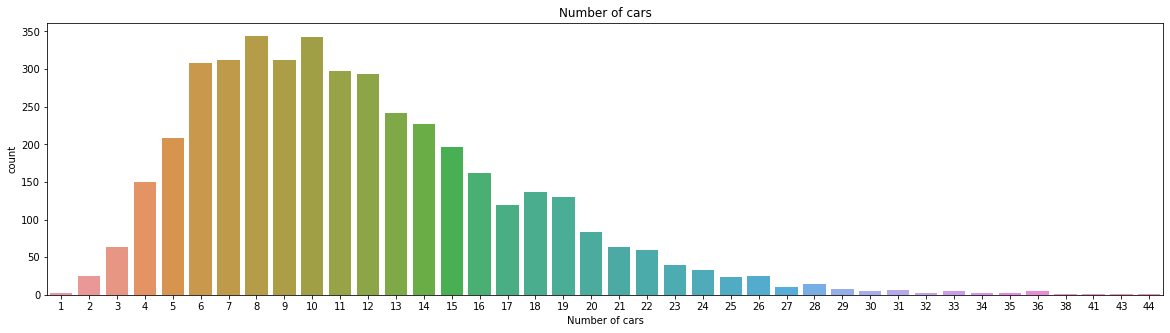

In [0]:
#@title Distribution du nombre de voitures par image
plt.figure(figsize=(20,5))
sns.countplot(liste['nb_car'])
plt.title('Number of cars')
plt.xlabel('Number of cars')
plt.show()

There is  49684 cars


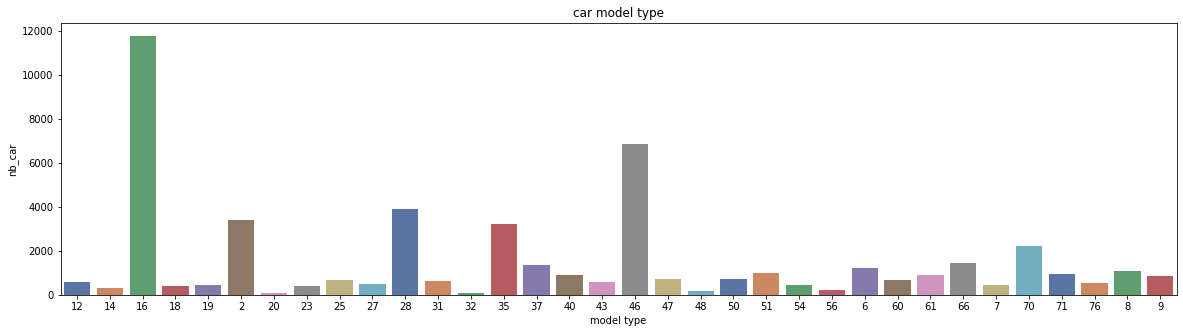

In [0]:
#@title Distribution des types de voitures
car_model = []
for i in range(liste.shape[0]):
    for j in range(len(liste['model_type'][i])):
        car_model.append(liste['model_type'][i][j])
test = pd.DataFrame(car_model)
test[1] = 1
test = test.groupby(by=0, as_index=True).sum()
test['model_type'] = test.index
test['nb_car'] = test[1]
test = test.sort_values(by=['model_type'])
print('There is ', test[1].sum(), 'cars')

# Distribution des type de voitures
plt.figure(figsize=(20,5))
sns.barplot(x='model_type', y='nb_car', data=test, palette="deep")
plt.title('car model type')
plt.xlabel('model type')
plt.show()

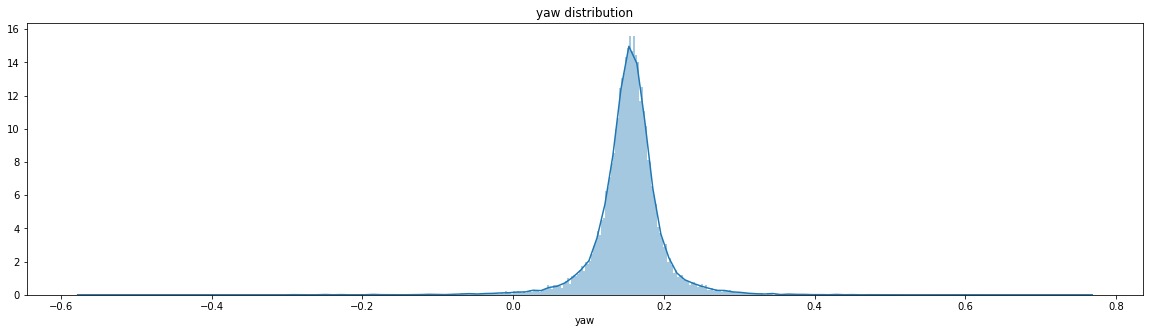

In [0]:
#@title Distribution des yaw
yaw_list = []
for i in range(liste.shape[0]):
    for j in range(len(liste['yaw'][i])):
        yaw_list.append(liste['yaw'][i][j])
test = pd.DataFrame(yaw_list)
test[0] = test[0].astype('float32')
plt.figure(figsize=(20,5))
plt.title('yaw distribution')
sns.distplot(test[0], bins=500);
plt.xlabel('yaw')
plt.show()

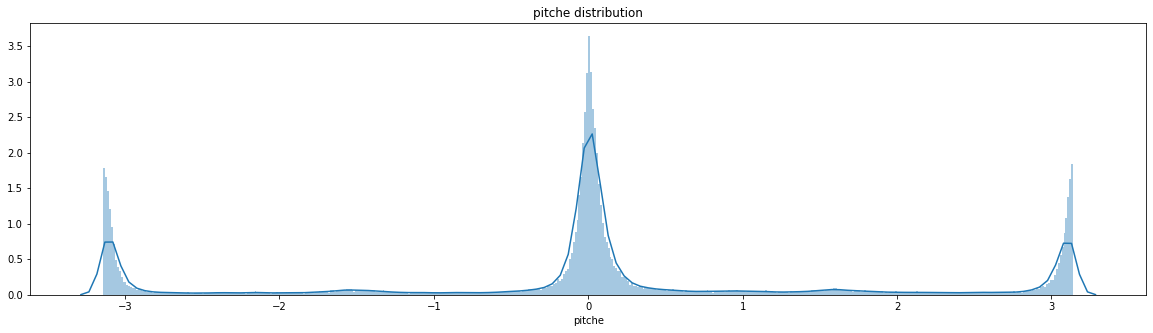

In [0]:
#@title Distribution des pitches
pitche_list = []
for i in range(liste.shape[0]):
    for j in range(len(liste['pitche'][i])):
        pitche_list.append(liste['pitche'][i][j])
test = pd.DataFrame(pitche_list)
test[0] = test[0].astype('float32')
plt.figure(figsize=(20,5))
plt.title('pitche distribution')
sns.distplot(test[0], bins=500);
plt.xlabel('pitche')
plt.show()

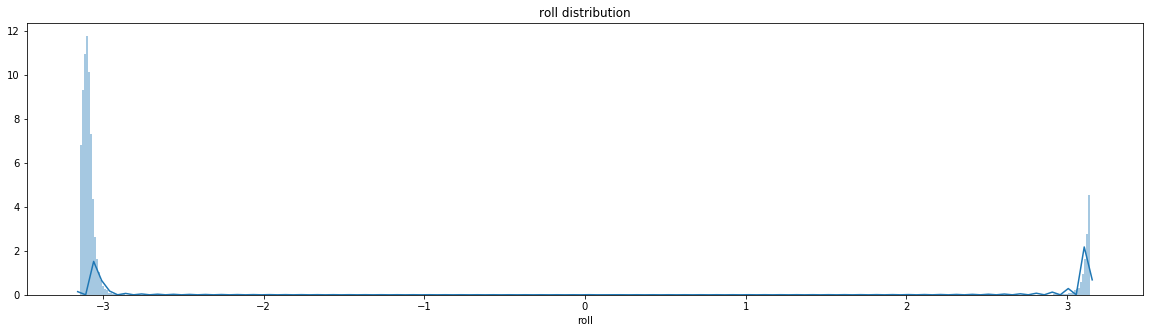

In [0]:
#@title Distribution des roll
roll_list = []
for i in range(liste.shape[0]):
    for j in range(len(liste['roll'][i])):
        roll_list.append(liste['roll'][i][j])
test = pd.DataFrame(roll_list)
test[0] = test[0].astype('float32')
plt.figure(figsize=(20,5))
plt.title('roll distribution')
sns.distplot(test[0], bins=500);
plt.xlabel('roll')
plt.show()

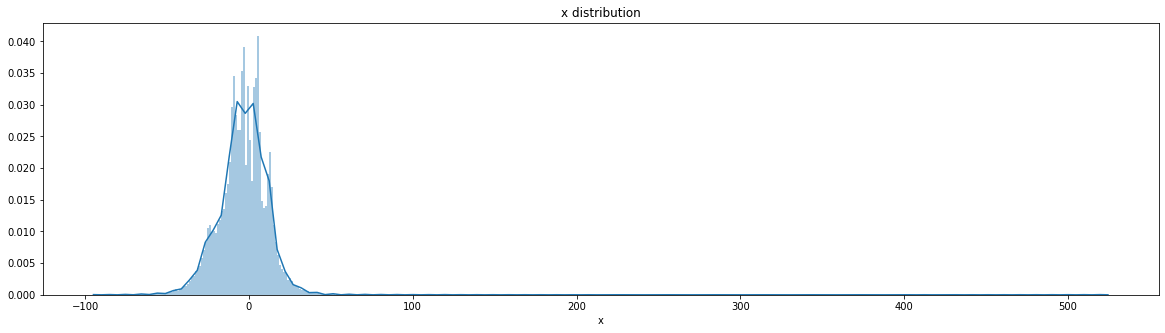

In [0]:
#@title Distribution des x
x_list = []
for i in range(liste.shape[0]):
    for j in range(len(liste['x'][i])):
        x_list.append(liste['x'][i][j])
test = pd.DataFrame(x_list)
test[0] = test[0].astype('float32')
plt.figure(figsize=(20,5))
plt.title('x distribution')
sns.distplot(test[0], bins=500);
plt.xlabel('x')
plt.show()

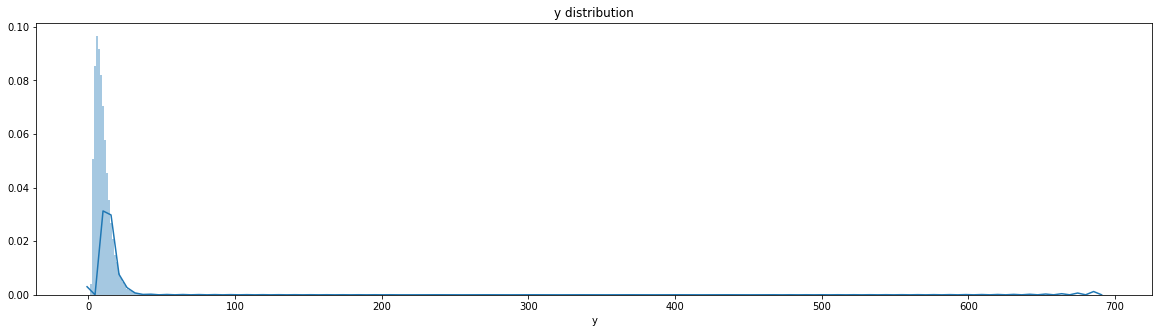

In [0]:
#@title Distribution des y
y_list = []
for i in range(liste.shape[0]):
    for j in range(len(liste['y'][i])):
        y_list.append(liste['y'][i][j])
test = pd.DataFrame(y_list)
test[0] = test[0].astype('float32')
plt.figure(figsize=(20,5))
plt.title('y distribution')
sns.distplot(test[0], bins=500);
plt.xlabel('y')
plt.show()

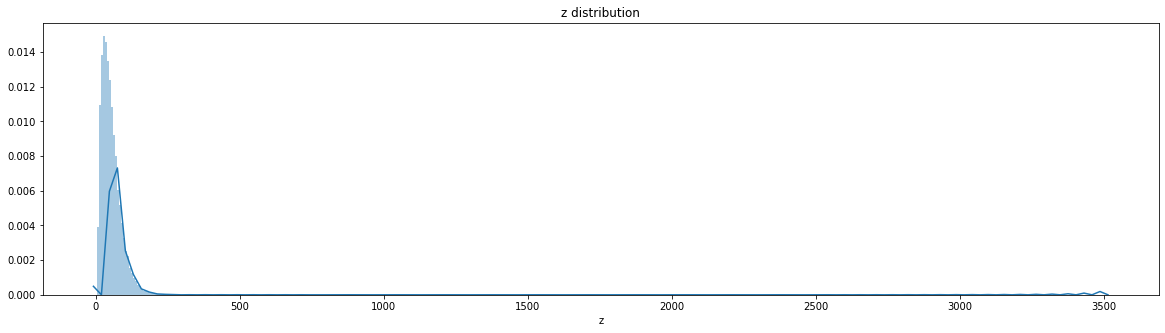

In [0]:
#@title Distribution des z
z_list = []
for i in range(liste.shape[0]):
    for j in range(len(liste['z'][i])):
        z_list.append(liste['z'][i][j])
test = pd.DataFrame(z_list)
test[0] = test[0].astype('float32')
plt.figure(figsize=(20,5))
plt.title('z distribution')
sns.distplot(test[0], bins=500);
plt.xlabel('z')
plt.show()

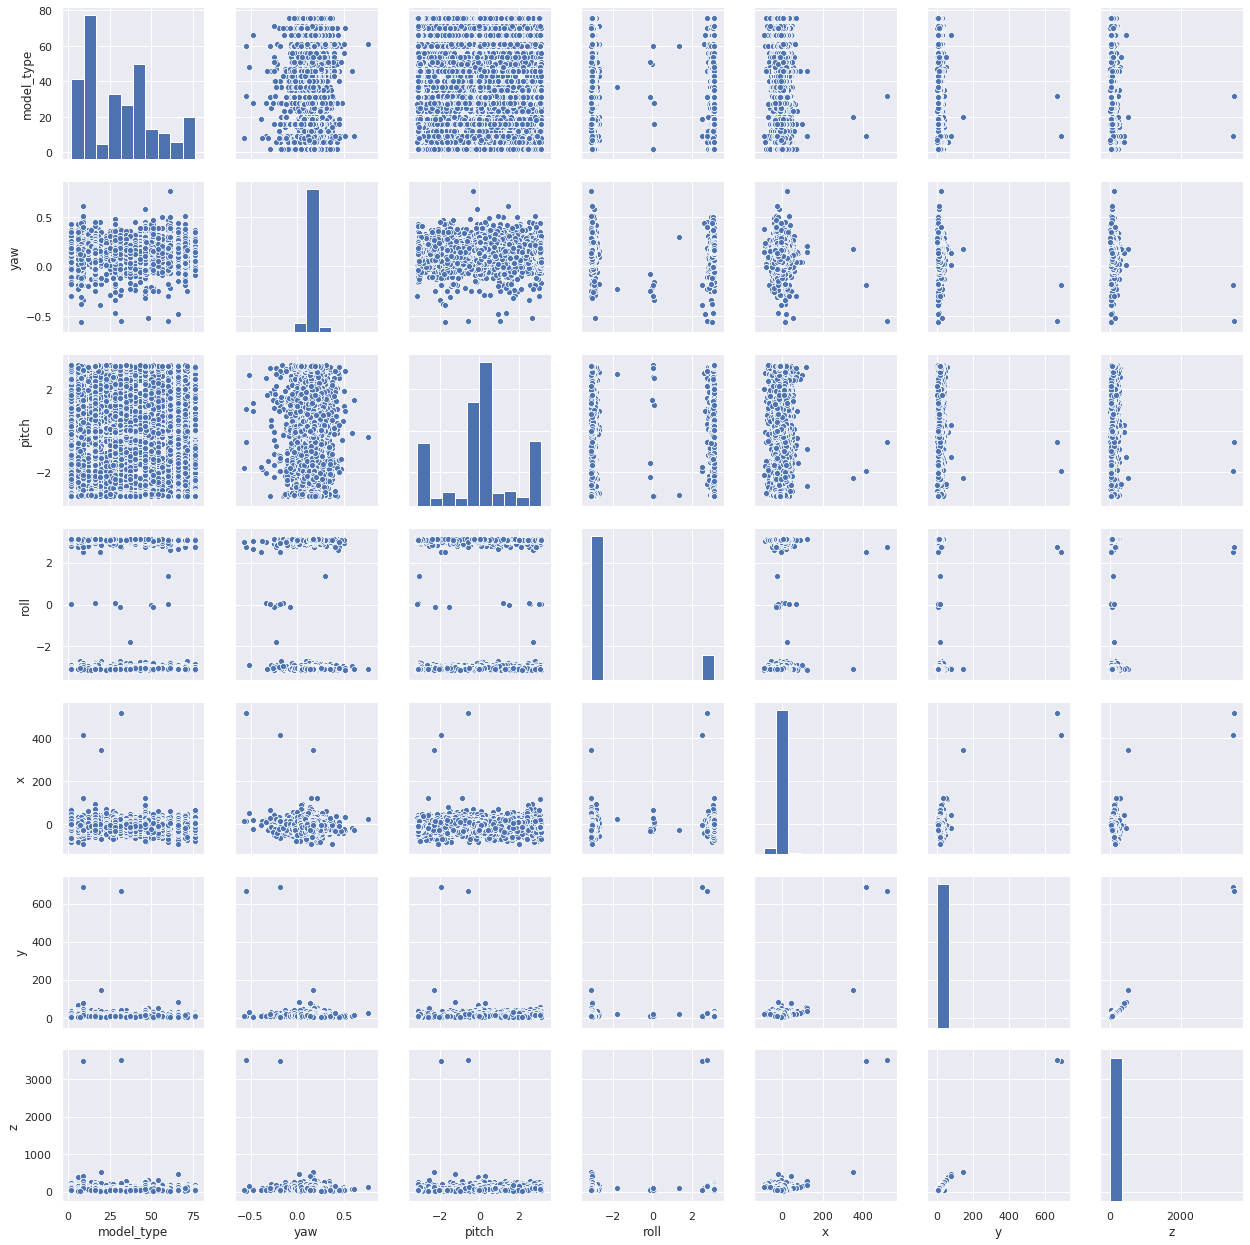

In [0]:
from collections import OrderedDict
def unpack(group):
    row = group.iloc[0]
    result = []
    data = row['PredictionString']
    while data:
        data = data.split(maxsplit=7)
        result.append(OrderedDict((
            ('image_id', row['ImageId']),
            ('model_type', int(data[0])),
            ('yaw', float(data[1])), 
            ('pitch', float(data[2])), 
            ('roll', float(data[3])), 
            ('x', float(data[4])), 
            ('y', float(data[5])),
            ('z', float(data[6]))
        )))
        data = data[7] if len(data) == 8 else ''
    return pd.DataFrame(result)

train_df = train[['ImageId', 'PredictionString']]
unpacked_train_df = train_df.groupby('ImageId', group_keys=False).apply(unpack).reset_index(drop=True)

sns.set()
sns.pairplot(unpacked_train_df)

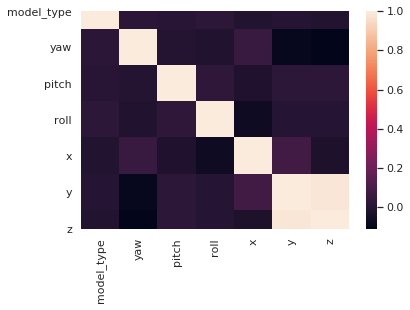

In [0]:
# calculate the correlation matrix
corr = unpacked_train_df.corr()

# plot the heatmap
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

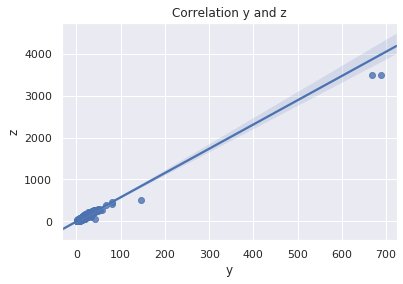

In [0]:
plt.title('Correlation y and z')
sns.regplot(unpacked_train_df['y'], unpacked_train_df['z'])

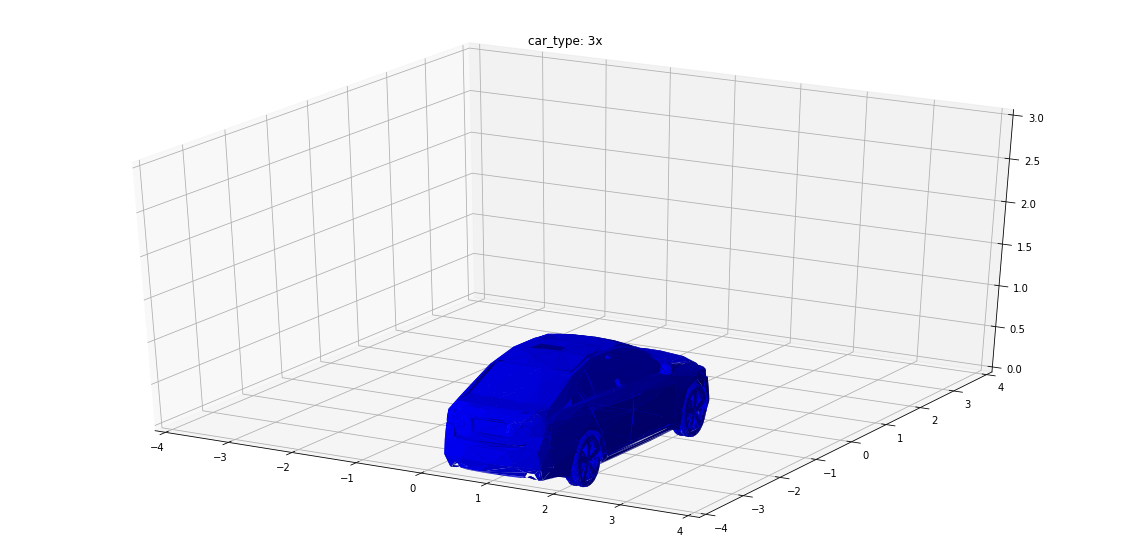

In [0]:
#@title On importe un fichier json
with open(car_models_json[0]) as json_file:
    data = json.load(json_file)
    vertices = np.array(data['vertices'])
    triangles = np.array(data['faces']) - 1
    plt.figure(figsize=(20,10))
    ax = plt.axes(projection='3d')
    ax.set_title('car_type: '+data['car_type'])
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([0, 3])
    ax.plot_trisurf(vertices[:,0],
                    vertices[:,2],
                    triangles,
                    -vertices[:,1], shade=True, color='blue')

<Figure size 1440x1440 with 0 Axes>

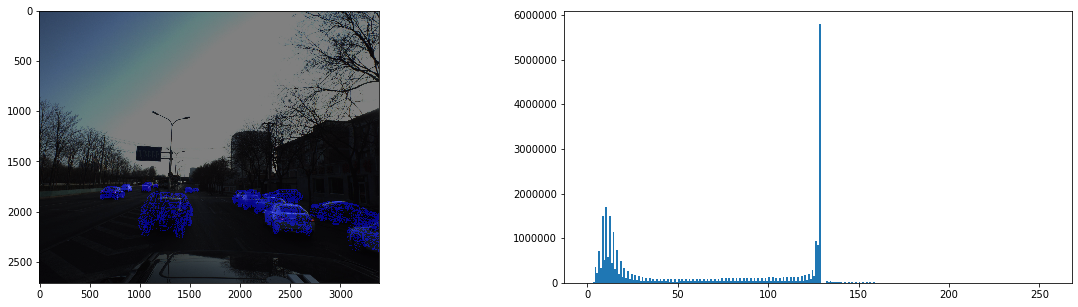

<Figure size 1440x1440 with 0 Axes>

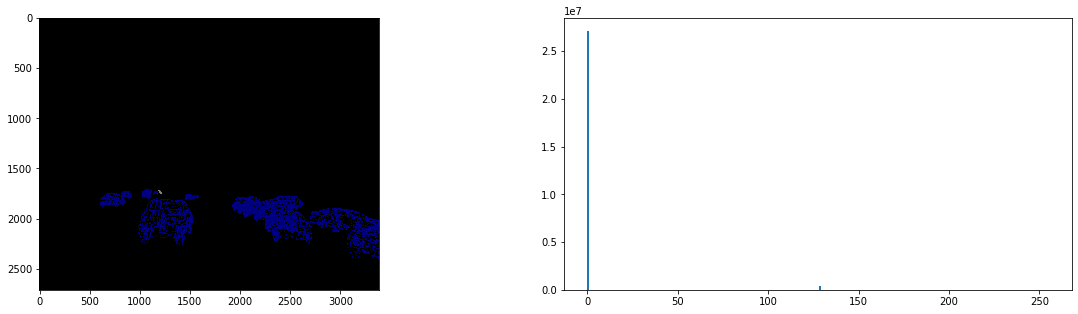

[model_types          28
 yaws           0.154079
 pitches         0.11061
 rolls          -3.10327
 xs             -12.7779
 ys              6.11575
 zs              31.1223
 Name: 0, dtype: object, model_types          25
 yaws            0.15316
 pitches        0.106944
 rolls          -3.11213
 xs             -19.3356
 ys              9.64266
 zs              54.8467
 Name: 1, dtype: object, model_types           70
 yaws            0.164431
 pitches        0.0836608
 rolls           -3.06783
 xs              -16.8311
 ys               11.2515
 zs               62.8933
 Name: 2, dtype: object, model_types            16
 yaws             0.166031
 pitches        -0.0443476
 rolls            -3.07248
 xs               -1.87776
 ys                3.17267
 zs                 11.461
 Name: 3, dtype: object, model_types           71
 yaws            0.149941
 pitches        -0.513609
 rolls           -3.09938
 xs               8.46959
 ys               8.82153
 zs               43.9451
 

In [0]:
#@title Augmented reality
# Load an image
img_name = train['ImageId'][50]
img = cv2.imread(f'Data/train_images/{img_name}.jpg',cv2.COLOR_BGR2RGB)[:,:,::-1]
img2 = cv2.imread(f'Data/train_masks/{img_name}.jpg',cv2.COLOR_BGR2RGB)[:,:,::-1]

# Prepare data
pred_string = train[train.ImageId == img_name].PredictionString.iloc[0]
items = pred_string.split(' ')
model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]
liste = pd.DataFrame([model_types, yaws, pitches, rolls, xs, ys, zs],
                            index=['model_types', 'yaws', 'pitches', 'rolls', 'xs', 'ys', 'zs'])
iterations = []
for i in list(liste.columns):
    iterations.append(liste[i])

# k is camera instrinsic matrix
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_obj(image, vertices, triangles):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
        # cv2.fillConvexPoly(image, coord, (0,0,255))
        cv2.polylines(image, np.int32([coord]), 1, (0,0,255))





overlay = np.zeros_like(img)
for model_type, yaw, pitch, roll, x, y, z in iterations:
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    # I think the pitch and yaw should be exchanged
    yaw, pitch, roll = -pitch, -yaw, -roll
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    #We open the model
    with open(car_models_json[int(model_type)]) as json_file:
        data = json.load(json_file)
        vertices = np.array(data['vertices'])
        vertices[:, 1] = -vertices[:, 1]
        triangles = np.array(data['faces']) - 1

    P = np.ones((vertices.shape[0],vertices.shape[1]+1))
    P[:, :-1] = vertices
    P = P.T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    draw_obj(overlay, img_cor_points, triangles)

# Print image
alpha = .5
img = np.array(img)
cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
plt.figure(figsize=(20,20))
print_image(img)
liste

# Print mask
alpha = .5
img2 = np.array(img2)
cv2.addWeighted(overlay, alpha, img2, 1 - alpha, 0, img2)
plt.figure(figsize=(20,20))
print_image(img2)
iterations

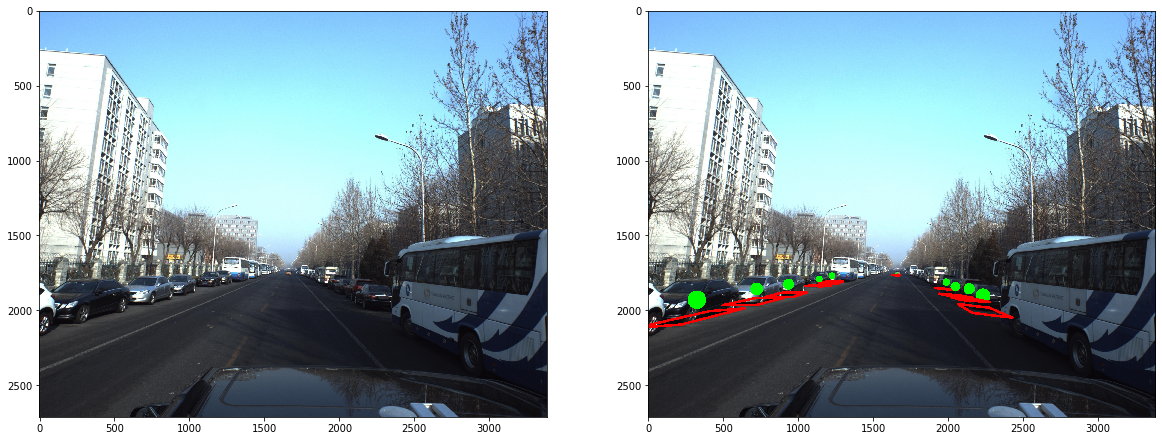

In [0]:
#@title Center plot
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)


def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img


def str2coords(s):
    pred_string = s
    items = pred_string.split(' ')
    model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]
    liste = pd.DataFrame([ model_types, yaws, pitches, rolls, xs, ys, zs],
                        index=['model_type', 'yaw', 'pitche', 'roll', 'x', 'y', 'z']).T
    coords = []
    for i in range(liste.shape[0]):
        coords.append({'id': float(liste['model_type'][i]),
                    'yaw': float(liste['yaw'][i]),
                    'pitch': float(liste['pitche'][i]),
                    'roll': float(liste['roll'][i]),
                    'x': float(liste['x'][i]),
                    'y': float(liste['y'][i]),
                    'z': float(liste['z'][i]),
                    })
    return coords

def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [float(c['x']) for c in coords]
    ys = [float(c['y']) for c in coords]
    zs = [float(c['z']) for c in coords]
    position = []
    for i in range(len(xs)):
        position.append([xs[i], ys[i], zs[i]])
    P = np.array(position).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image


def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

idx = 128


fig, axes = plt.subplots(1, 2, figsize=(20,20))
img = imread('Data/' + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
axes[0].imshow(img)
img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
axes[1].imshow(img_vis)
plt.show()

# Modélisation

On crée train et test

In [0]:
def image_format(i, border, size):
    image1 = Image.open(train['train_img'][i])
    image1 = ImageOps.expand(image1, border=border, fill=0)
    x = np.array(image1).shape[0]
    y = np.array(image1).shape[1]
    image1 = ImageOps.fit(image1, (max(x, y),max(x, y)),2, 0.0,(0.5,0.5))
    image1 = image1.resize((size, size), resample=0)
    return image1

In [0]:
def prepare_data(alpha=0.2, nb_pics=0.2, size=128, border=0):
    # On supprime les dossiers existants
    shutil.rmtree('Data/Train', True)
    shutil.rmtree('Data/Test', True)
    shutil.rmtree('Data/Val', True)
    # On créé les dossier d'entrainement
    create_repertory('Data/Train')
    # On créé les dossier de test
    create_repertory('Data/Test')
    # On créé les dossier de test
    create_repertory('Data/Val')


    liste_index_train = []      

    nb_pic = int(len(list(train['train_img'].index))*nb_pics)
    liste_index_train = random.sample(list(train['train_img'].index), nb_pic)
    a = int(len(liste_index_train)*alpha)
    liste_index_test = random.sample(liste_index_train, a)
    for j in liste_index_test:
        del liste_index_train[liste_index_train.index(j)]
    liste_index_val = random.sample(liste_index_train, a)
    for j in liste_index_val:
        del liste_index_train[liste_index_val.index(j)]
    # création du jeu d'entrainement
    for k in liste_index_train:
        img = image_format(k, border, size)
        img = img.save('Data/Train/' + train['ImageId'][k] + '.jpg')
    # création du jeu de test
    for k in liste_index_test:
        img = image_format(k, border, size)
        img = img.save('Data/Test/' + train['ImageId'][k] + '.jpg') 
    # création du jeu de val
    for k in liste_index_val:
        img = image_format(k, border, size)
        img = img.save('Data/Val/' + train['ImageId'][k] + '.jpg')
    return liste_index_train, liste_index_test, liste_index_val

In [0]:
import random
liste_index_train, liste_index_test, liste_index_val = prepare_data(alpha=0.2, nb_pics=0.2, size=512, border=0)

## NB_car

In [0]:
#@title Création du DataFrame train
images = []
model_type = []
yaw = []
pitche = []
roll = []
x = []
y = []
z = []

for i in list(range(0,train.shape[0])):
    pred_string = train.PredictionString.iloc[i]
    items = pred_string.split(' ')
    model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]
    model_type.append(model_types)
    yaw.append(yaws)
    pitche.append(pitches)
    roll.append(rolls)
    x.append(xs)
    y.append(ys)
    z.append(zs)
    images.append(train.loc[i, 'ImageId'])
liste = pd.DataFrame([images, model_type, yaw, pitche, roll, x, y, z],
                     index=['ImageId', 'model_type', 'yaw', 'pitche', 'roll', 'x', 'y', 'z']).T
liste['nb_car'] = [len(liste['model_type'][i]) for i in range(liste.shape[0])]

In [0]:
x_train = train['train_img'][liste_index_train]
x_test = train['train_img'][liste_index_test]
x_val = train['train_img'][liste_index_val]
y_train = liste['nb_car'][liste_index_train]/44
y_test = liste['nb_car'][liste_index_test]/44
y_val = liste['nb_car'][liste_index_val]/44

# Pour l'entrainnement
new_train = pd.DataFrame({"x":x_train})
new_train = new_train.join(y_train)

new_test = pd.DataFrame({"x":x_test})
new_test = new_test.join(y_test)

# Pour la validation
new_val = pd.DataFrame({"x":x_val})
new_val = new_val.join(y_val)
# On corrige les chemins d'accès
new_train['x'] = new_train['x'].str.replace('train_images', 'Train')
new_test['x'] = new_test['x'].str.replace('train_images', 'Test')
new_val['x'] = new_val['x'].str.replace('train_images', 'Val')

In [0]:
def score(y_true, y_pred):
    if not K.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return K.sum(K.abs(y_true/y_true)) / K.sum(K.abs(y_pred/y_true))

In [0]:
def sum_absolute_error(y_true, y_pred):
    if not K.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return K.sum(K.abs(y_pred - y_true), axis=-1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_603 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_603 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_603 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_604 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_604 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_604 (MaxPoolin (None, 127, 127, 4)       0         
__________

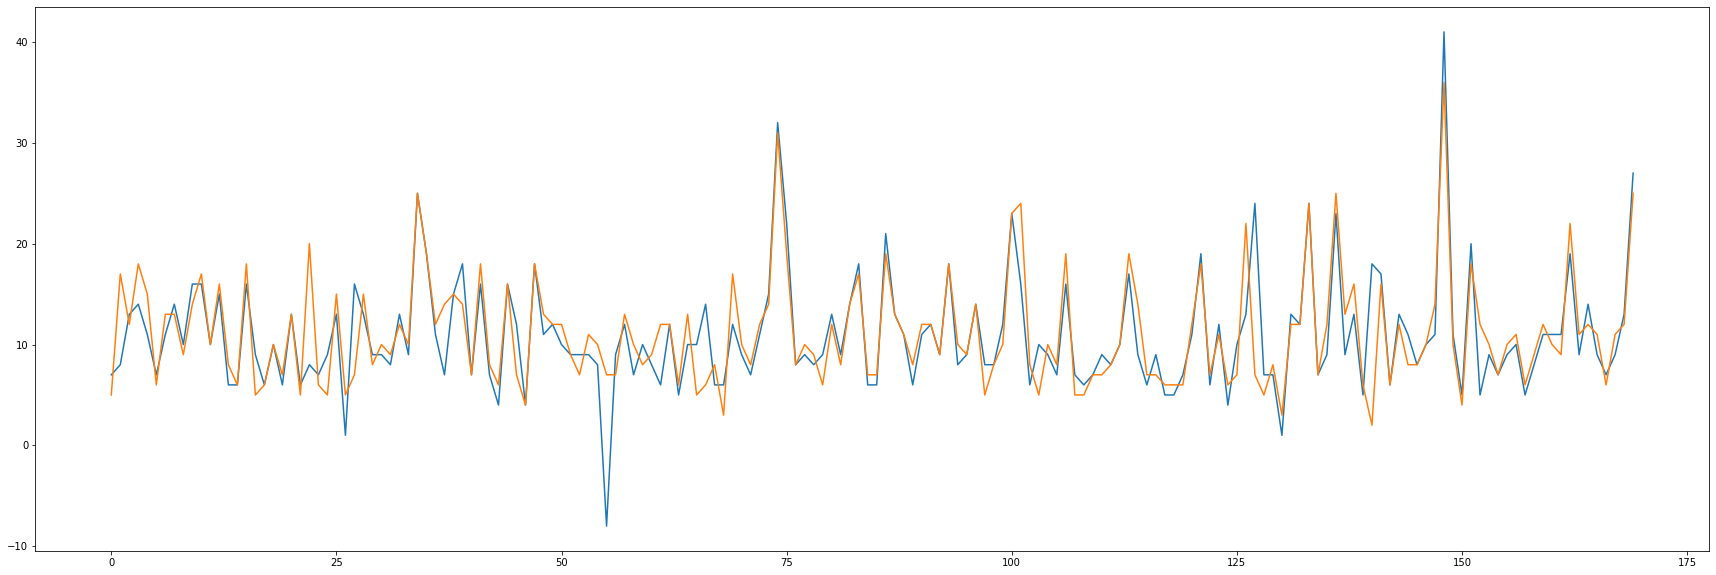

In [0]:
from keras.layers.merge import add, concatenate
# parametres
img_size = 512
nb_conv = 6
nb_dense = 4
units = 512
dropout = 0.5
# construction du modèle
input_shape = (img_size, img_size, 3)

x = Input(shape=input_shape)
l = x
l = Convolution2D(filters=2, kernel_size=[1, 1], strides=1, activation="relu")(l)
l = BatchNormalization()(l)
l = MaxPooling2D()(l)

for i in list(range(nb_conv)): 
    l = Convolution2D(filters=2*(2**(i//2+1)), kernel_size=[3, 3], strides=1, activation="relu")(l)
    l = BatchNormalization()(l)
    l = MaxPooling2D(pool_size=(2, 2), strides=2)(l)
# Couche Flattening
l = Flatten()(l)


l = Dense(units=1024, activation="relu")(l)
l = Dropout(dropout)(l)



l = Dense(units=1, activation="linear")(l)

first_model = models.Model(x, l)
first_model.compile(loss=sum_absolute_error, optimizer='adam', metrics=[score])


first_model.summary()



train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_dataframe(new_train,
                                                 directory=None,
                                                 x_col='x',
                                                 y_col='nb_car',
                                                 weight_col=None,
                                                 target_size=(img_size, img_size),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=None,
                                                 save_to_dir=None,
                                                 save_prefix='',
                                                 save_format='jpg',
                                                 subset=None,
                                                 interpolation='nearest', 
                                                 validate_filenames=True)

test_set = test_datagen.flow_from_dataframe(new_test,
                                            directory=None,
                                            x_col='x',
                                            y_col='nb_car',
                                            weight_col=None,
                                            target_size=(img_size, img_size),
                                            color_mode='rgb',
                                            classes=None,
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix='',
                                            save_format='jpg',
                                            subset=None,
                                            interpolation='nearest', 
                                            validate_filenames=True)

val_set = test_datagen.flow_from_dataframe(new_val,
                                            directory=None,
                                            x_col='x',
                                            y_col='nb_car',
                                            weight_col=None,
                                            target_size=(img_size, img_size),
                                            color_mode='rgb',
                                            classes=None,
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix='',
                                            save_format='jpg',
                                            subset=None,
                                            interpolation='nearest', 
                                            validate_filenames=True)

checkpoint = ModelCheckpoint("nb_car.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)



History = first_model.fit_generator(training_set,
                                    steps_per_epoch=int(math.ceil(len(training_set.filenames)/32)), # len du jeux d'entrainement / batch
                                    epochs=100,
                                    validation_data=test_set,
                                    validation_steps=int(math.ceil(len(test_set.filenames)/32)), # len du jeux de test / batch
                                    callbacks = [checkpoint],
                                    workers=2)


plt.figure(figsize=(30,10))
y_hat = []
for i in list(range(len(val_set.filepaths))):
    test_image = Image.open(val_set.filepaths[i])
    test_image_full = np.array(test_image)
    test_image = test_image.resize((img_size, img_size), resample=0)
    test_image = np.array(test_image)/255
    test_image = np.expand_dims(test_image, axis=0)
    result = first_model.predict(test_image)
    y_hat.append(int(result[0]*44))

    
plt.plot(y_hat)
plt.plot(list(liste['nb_car'][liste_index_val]))
ecart = np.mean(np.abs(np.array(y_hat) - liste['nb_car'][liste_index_val]))
print('mean absolute error: ', ecart)

## Positions

In [0]:
x_train = train['train_img'][liste_index_train]
x_test = train['train_img'][liste_index_test]
x_val = train['train_img'][liste_index_val]
y_train = train['PredictionString'].str.split(' ', expand=True).astype('float32').loc[liste_index_train,:].fillna(value=0)

#normalize_min = list(train['PredictionString'].str.split(' ', expand=True).astype('float32').loc[liste_index_train,:].fillna(value=0).min())
normalize_min = 0
normalize_max = list(abs(train['PredictionString'].str.split(' ', expand=True).astype('float32').loc[liste_index_train,:].fillna(value=0)).max())

y_train = (y_train-normalize_min)/normalize_max
y_train = y_train.fillna(value=0)
y_test = train['PredictionString'].str.split(' ', expand=True).astype('float32').loc[liste_index_test,:].fillna(value=0)
y_test = (y_test-normalize_min)/normalize_max
y_test = y_test.fillna(value=0)
y_val = train['PredictionString'].str.split(' ', expand=True).astype('float32').loc[liste_index_val,:].fillna(value=0)
y_val = (y_val-normalize_min)/normalize_max
y_val = y_val.fillna(value=0)

# Pour l'entrainnement
new_train = pd.DataFrame({"x":x_train})
new_train = new_train.join(y_train)

new_test = pd.DataFrame({"x":x_test})
new_test = new_test.join(y_test)

# Pour la validation
new_val = pd.DataFrame({"x":x_val})
new_val = new_val.join(y_val)

# On corrige les chemins d'accès
new_train['x'] = new_train['x'].str.replace('train_images', 'Train')
new_test['x'] = new_test['x'].str.replace('train_images', 'Test')
new_val['x'] = new_val['x'].str.replace('train_images', 'Val')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_498 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_498 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_498 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_499 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_499 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_499 (MaxPoolin (None, 127, 127, 4)       0         
__________

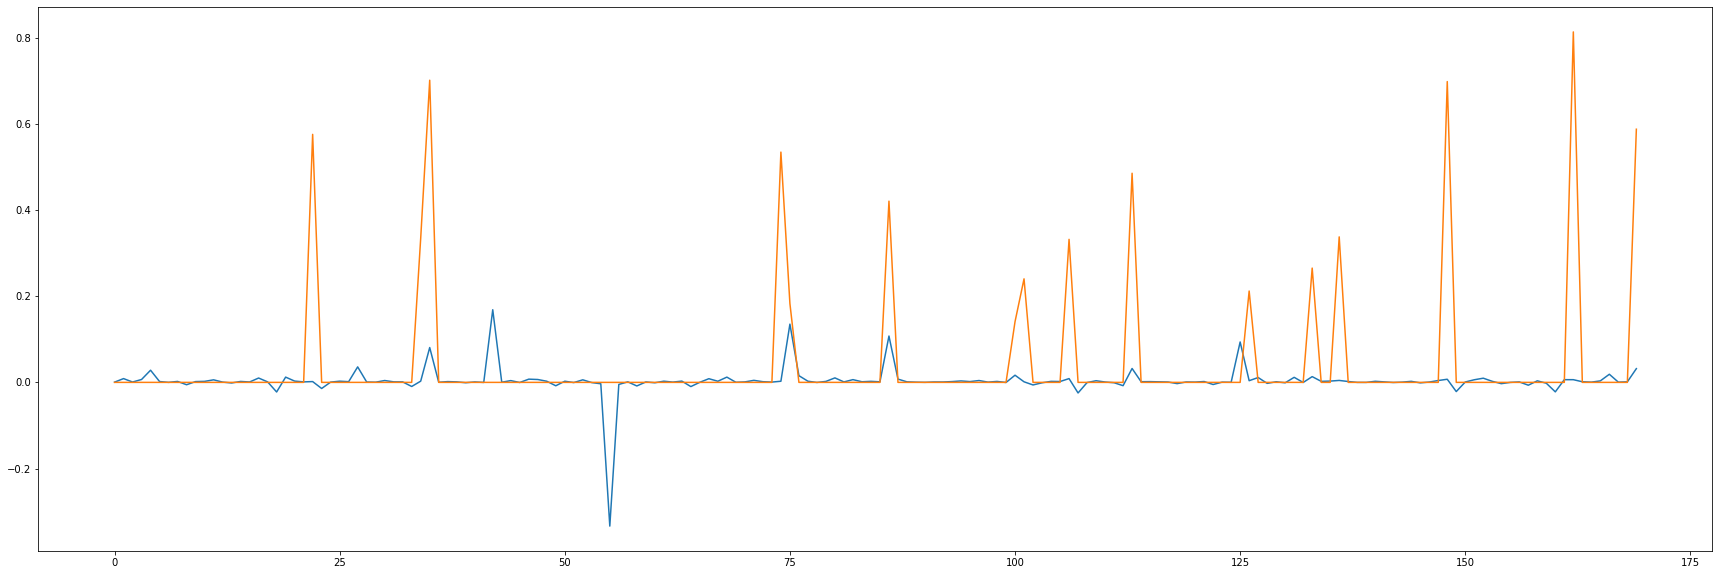

mean absolute error:  0.0488609469184343
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_505 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_505 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_505 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_506 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_506 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_506 (MaxPoolin (None,

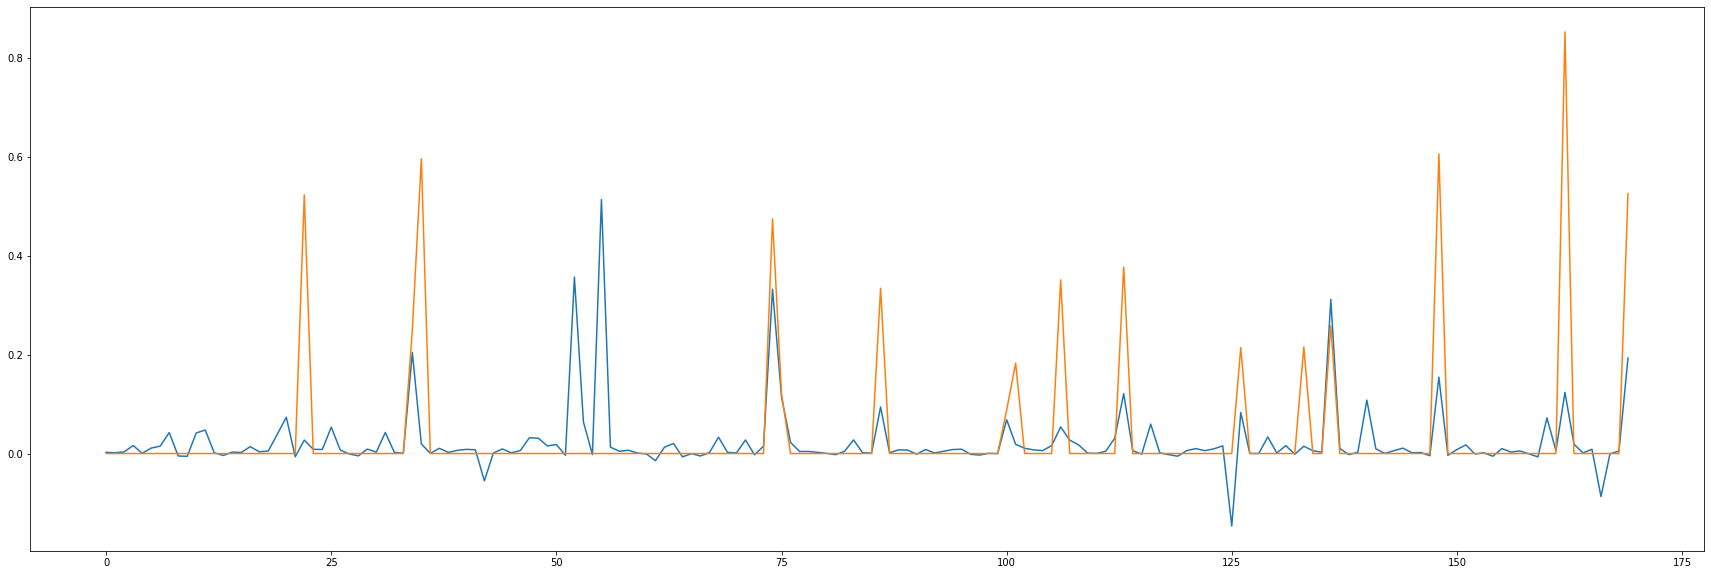

mean absolute error:  0.05853260538420337
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_512 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_512 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_512 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_513 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_513 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_513 (MaxPoolin (None

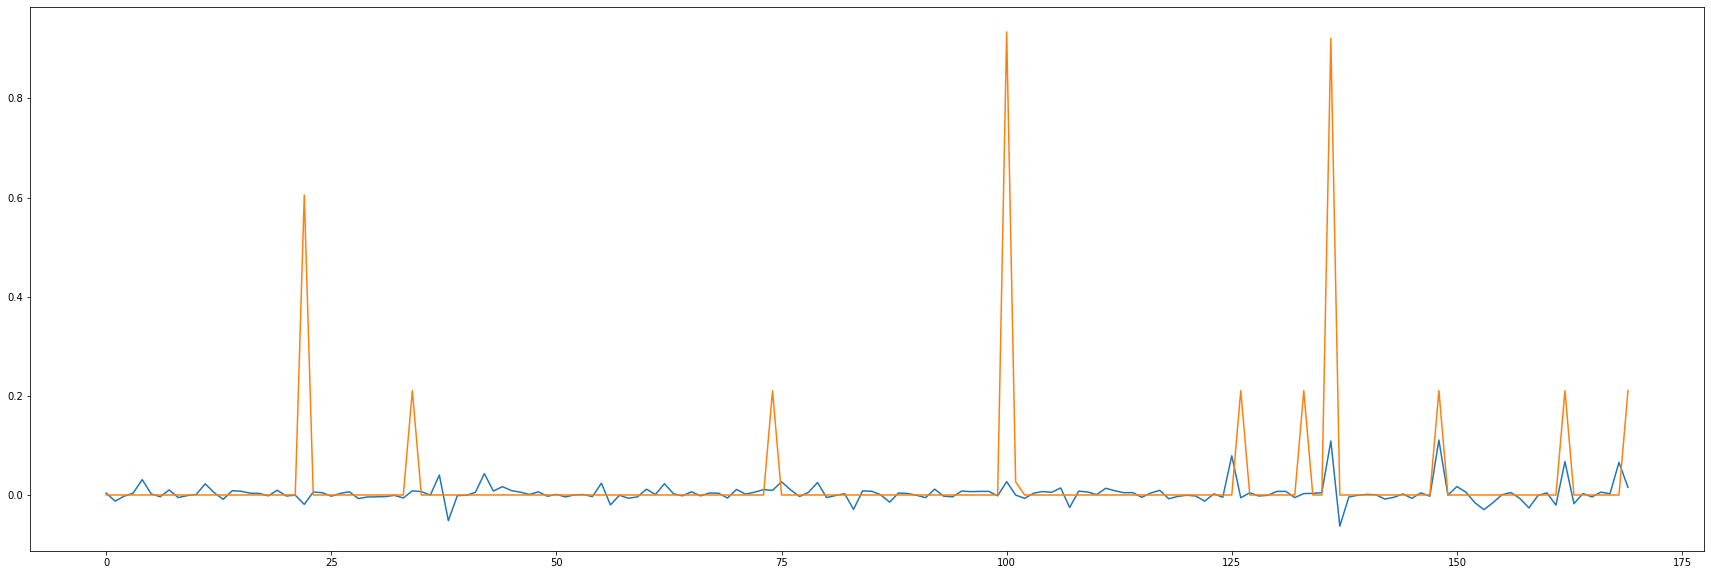

mean absolute error:  0.032679829862376414
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_519 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_519 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_519 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_520 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_520 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_520 (MaxPoolin (Non

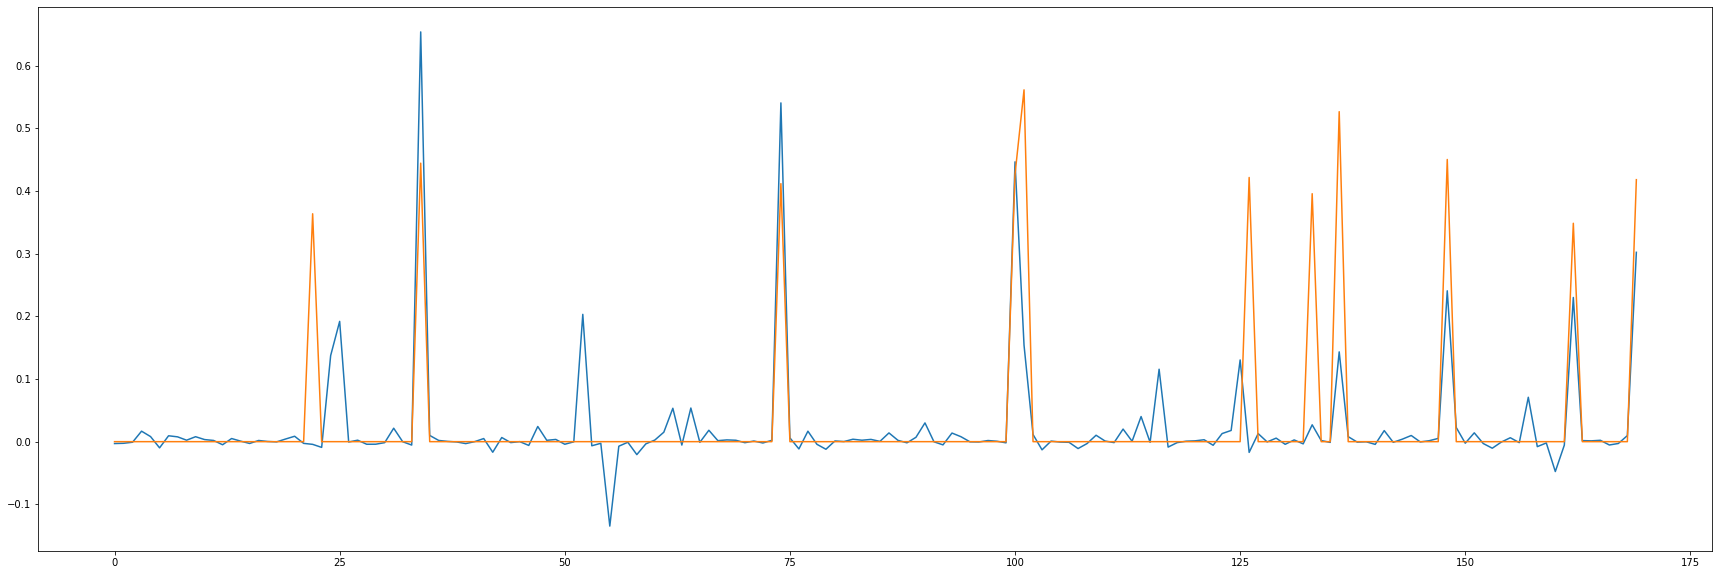

mean absolute error:  0.052948810216190474
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_526 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_526 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_526 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_527 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_527 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_527 (MaxPoolin (Non

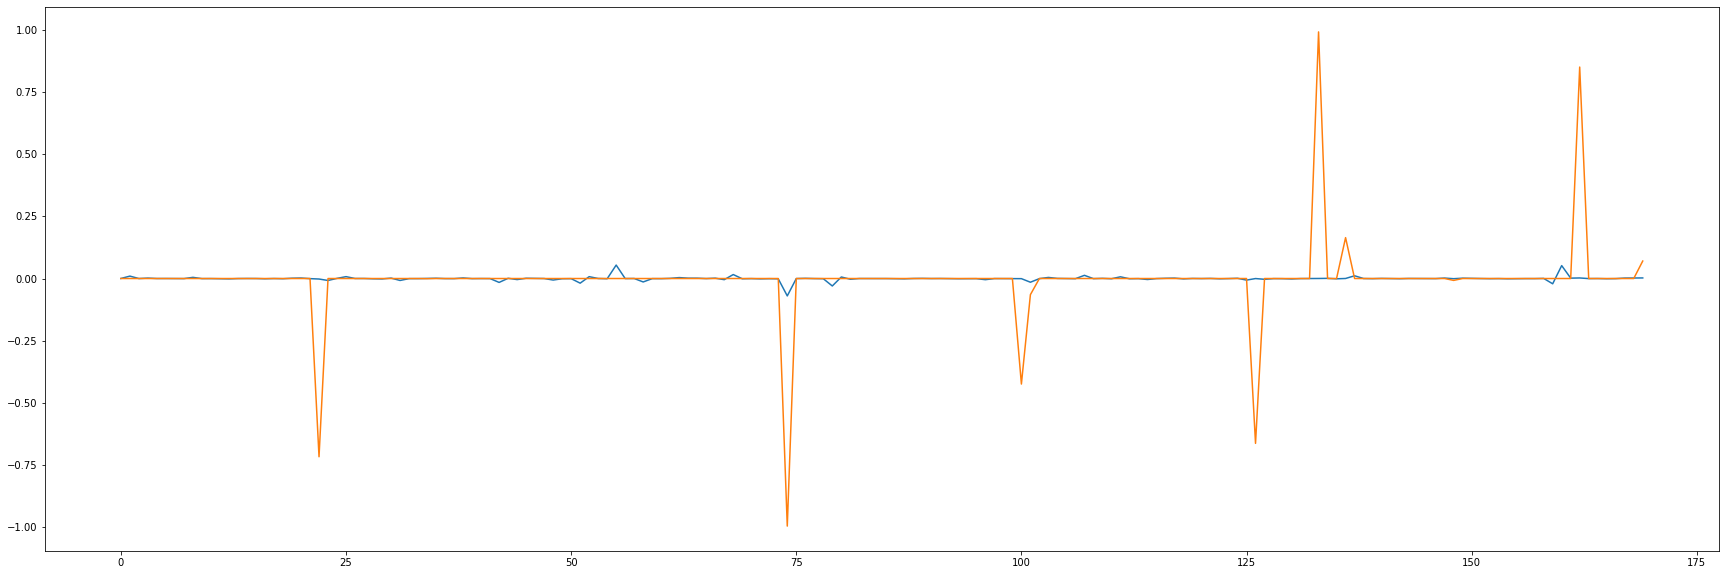

mean absolute error:  0.03198837636115801
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_533 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_533 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_533 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_534 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_534 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_534 (MaxPoolin (None

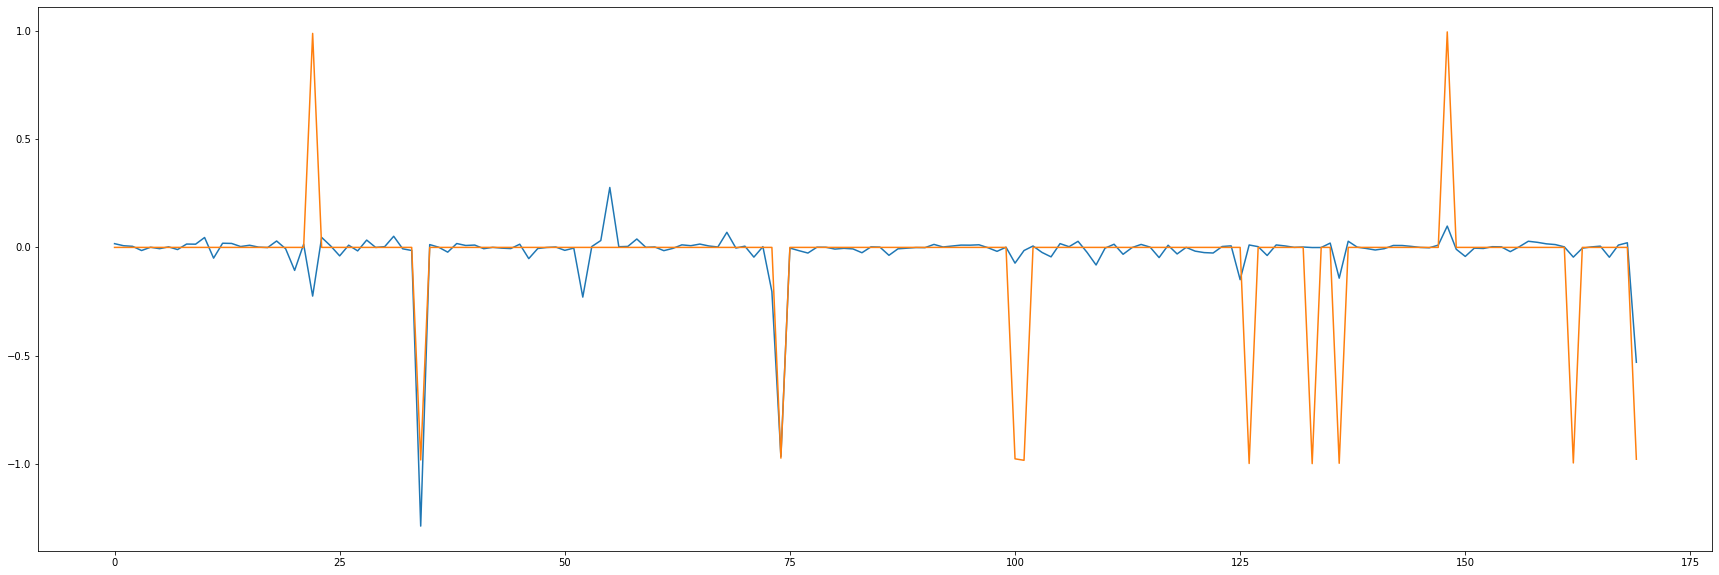

mean absolute error:  0.09860444760987709
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_540 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_540 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_540 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_541 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_541 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_541 (MaxPoolin (None

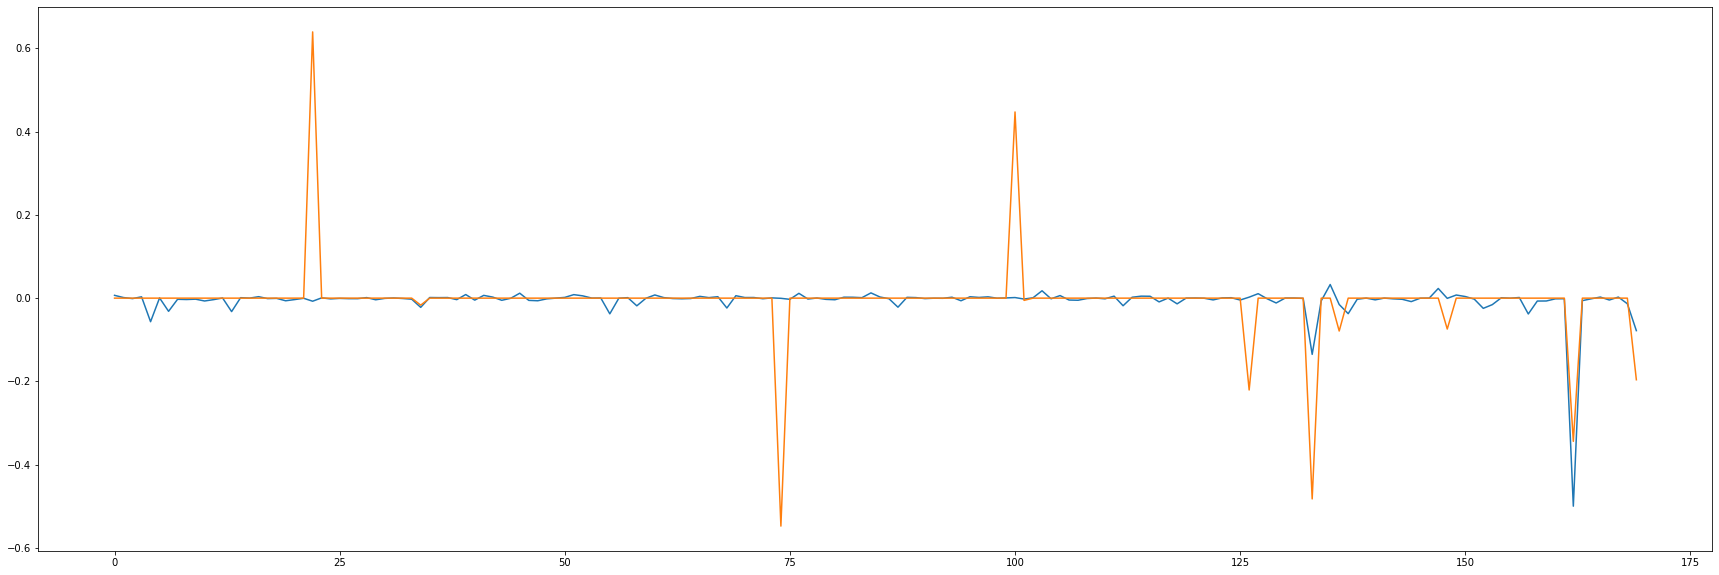

mean absolute error:  0.02687613426143584
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_547 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_547 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_547 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_548 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_548 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_548 (MaxPoolin (None

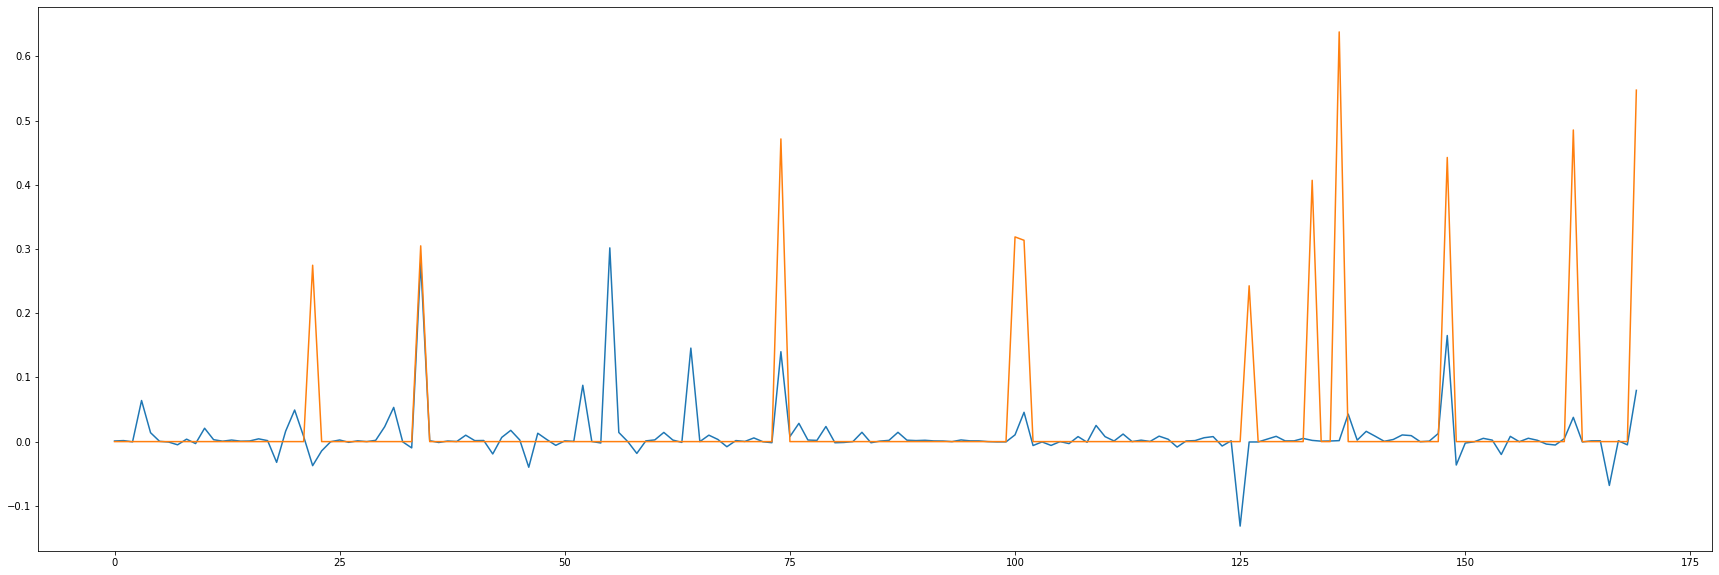

mean absolute error:  0.03965519889579098
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_554 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_554 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_554 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_555 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_555 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_555 (MaxPoolin (None

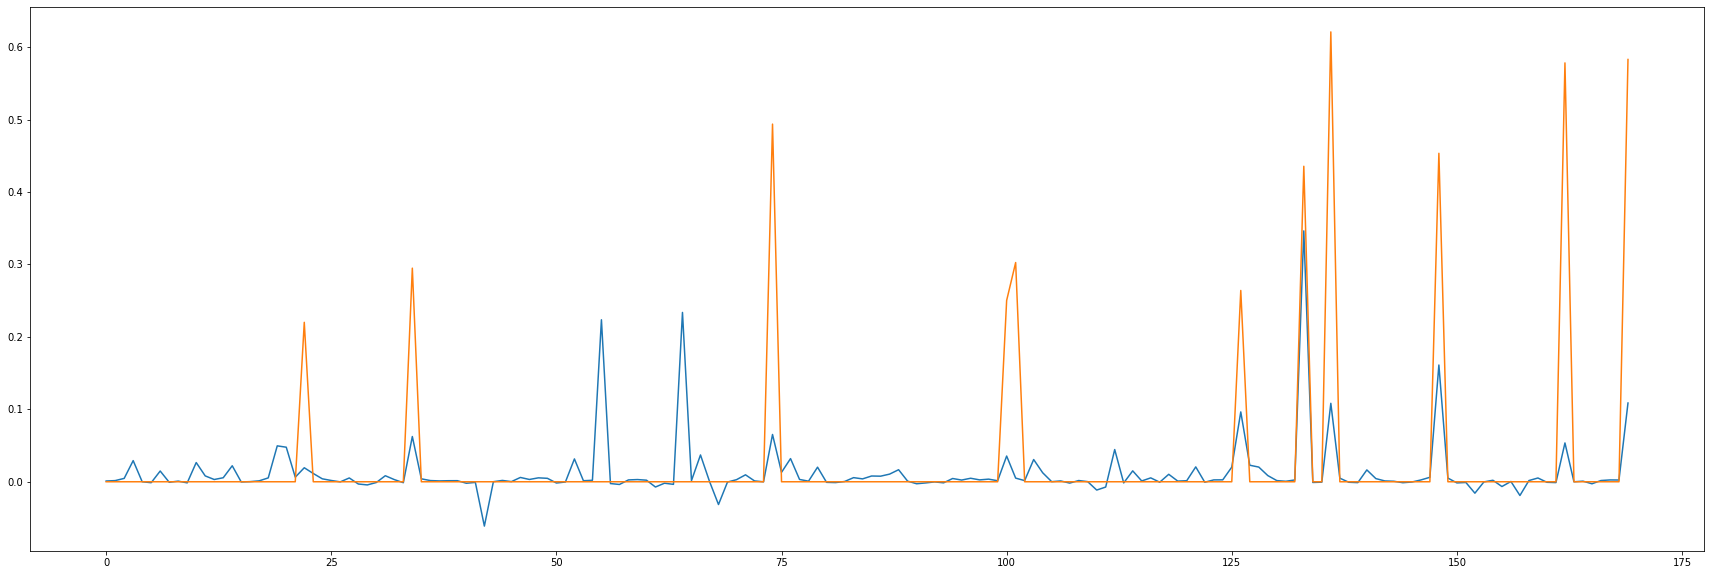

mean absolute error:  0.03973080362463076
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_561 (Conv2D)          (None, 512, 512, 2)       8         
_________________________________________________________________
batch_normalization_561 (Bat (None, 512, 512, 2)       8         
_________________________________________________________________
max_pooling2d_561 (MaxPoolin (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d_562 (Conv2D)          (None, 254, 254, 4)       76        
_________________________________________________________________
batch_normalization_562 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
max_pooling2d_562 (MaxPoolin (None

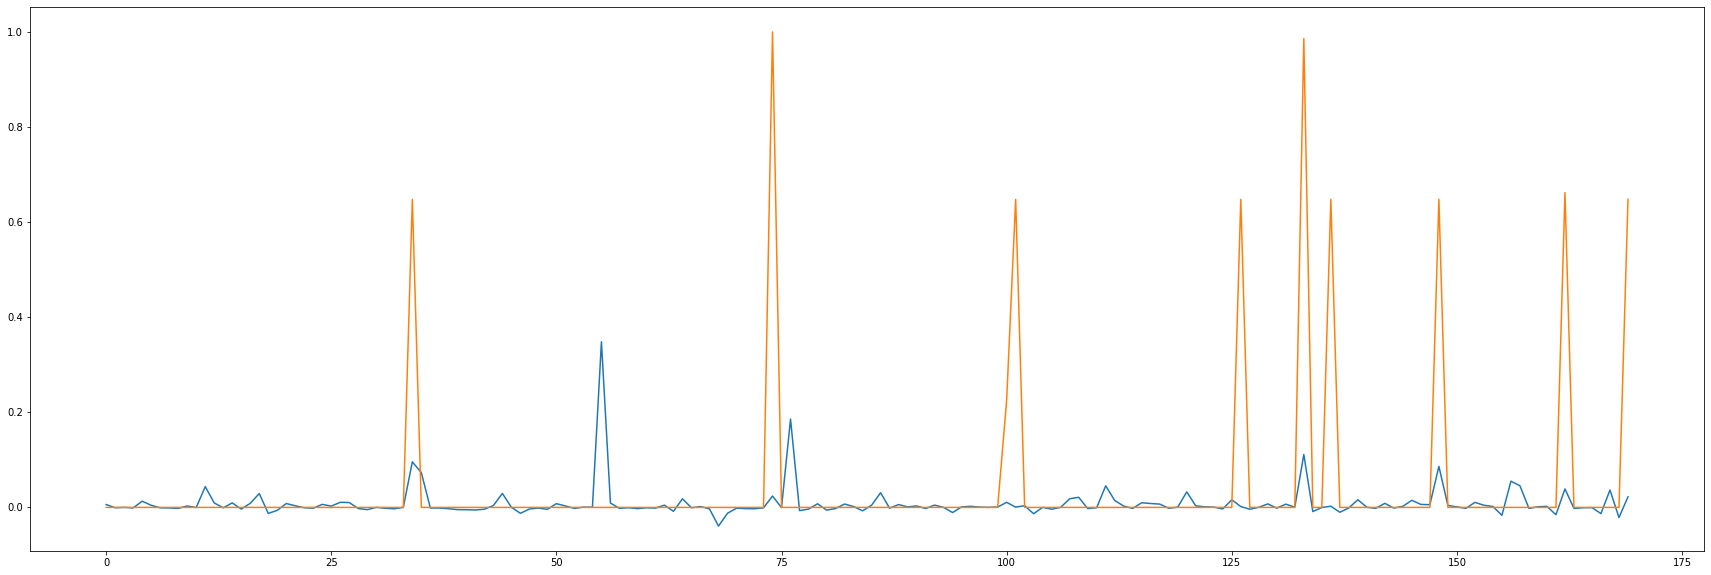

mean absolute error:  0.050806085278614826


In [0]:
# parametres
col = list(range(131, 141))
img_size = 512
nb_conv = 6
nb_dense = 4
units = 512
dropout = 0.5
# construction du modèle
input_shape = (img_size, img_size, 3)
for k in col:
    x = Input(shape=input_shape)
    l = x
    l = Convolution2D(filters=2, kernel_size=[1, 1], strides=1, activation="relu")(l)
    l = BatchNormalization()(l)
    l = MaxPooling2D()(l)

    for i in list(range(nb_conv)): 
        l = Convolution2D(filters=2*(2**(i//2+1)), kernel_size=[3, 3], strides=1, activation="relu")(l)
        l = BatchNormalization()(l)
        l = MaxPooling2D(pool_size=(2, 2), strides=2)(l)
    # Couche Flattening
    l = Flatten()(l)


    l = Dense(units=1024, activation="relu")(l)
    l = Dropout(dropout)(l)



    l = Dense(units=1, activation="linear")(l)

    train_model = models.Model(x, l)
    train_model.compile(loss=sum_absolute_error, optimizer='adam', metrics=[score])


    train_model.summary()



    train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    training_set = train_datagen.flow_from_dataframe(new_train,
                                                    directory=None,
                                                    x_col='x',
                                                    y_col=k,
                                                    weight_col=None,
                                                    target_size=(img_size, img_size),
                                                    color_mode='rgb',
                                                    classes=None,
                                                    class_mode='raw',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    seed=None,
                                                    save_to_dir=None,
                                                    save_prefix='',
                                                    save_format='jpg',
                                                    subset=None,
                                                    interpolation='nearest', 
                                                    validate_filenames=True)

    test_set = test_datagen.flow_from_dataframe(new_test,
                                                directory=None,
                                                x_col='x',
                                                y_col=k,
                                                weight_col=None,
                                                target_size=(img_size, img_size),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='raw',
                                                batch_size=32,
                                                shuffle=True,
                                                seed=None,
                                                save_to_dir=None,
                                                save_prefix='',
                                                save_format='jpg',
                                                subset=None,
                                                interpolation='nearest', 
                                                validate_filenames=True)

    val_set = test_datagen.flow_from_dataframe(new_val,
                                                directory=None,
                                                x_col='x',
                                                y_col=k,
                                                weight_col=None,
                                                target_size=(img_size, img_size),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='raw',
                                                batch_size=32,
                                                shuffle=True,
                                                seed=None,
                                                save_to_dir=None,
                                                save_prefix='',
                                                save_format='jpg',
                                                subset=None,
                                                interpolation='nearest', 
                                                validate_filenames=True)
    model_name = 'model' + str(k) + '.h5'
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=1, mode='auto')


    History = train_model.fit_generator(training_set,
                                        steps_per_epoch=int(math.ceil(len(training_set.filenames)/32)), # len du jeux d'entrainement / batch
                                        epochs=50,
                                        validation_data=test_set,
                                        validation_steps=int(math.ceil(len(test_set.filenames)/32)), # len du jeux de test / batch
                                        callbacks = [checkpoint, early],
                                        workers=2)


    plt.figure(figsize=(30,10))
    y_hat = []
    for i in list(range(len(val_set.filepaths))):
        test_image = Image.open(val_set.filepaths[i])
        test_image_full = np.array(test_image)
        test_image = test_image.resize((img_size, img_size), resample=0)
        test_image = np.array(test_image)/255
        test_image = np.expand_dims(test_image, axis=0)
        result = train_model.predict(test_image)
        y_hat.append(result[0])

        
    plt.plot(y_hat)
    plt.plot(list(new_val[k]))
    plt.show()
    ecart = np.mean(np.abs(np.array(y_hat) - list(new_val[k])))
    print('mean absolute error: ', ecart)

# Evaluation

In [0]:
from keras.models import load_model
# create models
x = Input(shape=(512, 512 ,3))
l = x
l = Convolution2D(filters=2, kernel_size=[1, 1], strides=1, activation="relu")(l)
l = BatchNormalization()(l)
l = MaxPooling2D()(l)

for i in list(range(6)): 
    l = Convolution2D(filters=2*(2**(i//2+1)), kernel_size=[3, 3], strides=1, activation="relu")(l)
    l = BatchNormalization()(l)
    l = MaxPooling2D(pool_size=(2, 2), strides=2)(l)
# Couche Flattening
l = Flatten()(l)
l = Dense(units=1024, activation="relu")(l)
l = Dropout(0.5)(l)
l = Dense(units=1, activation="linear")(l)

train_model = models.Model(x, l)
train_model.compile(loss=sum_absolute_error, optimizer='adam', metrics=[score])

x = Input(shape=(512,512,3))
l = x
l = Convolution2D(filters=2, kernel_size=[1, 1], strides=1, activation="relu")(l)
l = BatchNormalization()(l)
l = MaxPooling2D()(l)
for i in list(range(6)): 
    l = Convolution2D(filters=2*(2**(i//2+1)), kernel_size=[3, 3], strides=1, activation="relu")(l)
    l = BatchNormalization()(l)
    l = MaxPooling2D(pool_size=(2, 2), strides=2)(l)
# Couche Flattening
l = Flatten()(l)
l = Dense(units=1024, activation="relu")(l)
l = Dropout(0.5)(l)
l = Dense(units=1, activation="linear")(l)
first_model = models.Model(x, l)
first_model.compile(loss=sum_absolute_error, optimizer='adam', metrics=[score])

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_dataframe(new_train,
                                                directory=None,
                                                x_col='x',
                                                y_col=list(range(1,308)),
                                                weight_col=None,
                                                target_size=(512, 512),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='raw',
                                                batch_size=32,
                                                shuffle=True,
                                                seed=None,
                                                save_to_dir=None,
                                                save_prefix='',
                                                save_format='jpg',
                                                subset=None,
                                                interpolation='nearest', 
                                                validate_filenames=True)

test_set = test_datagen.flow_from_dataframe(new_test,
                                            directory=None,
                                            x_col='x',
                                            y_col=list(range(1,308)),
                                            weight_col=None,
                                            target_size=(512, 512),
                                            color_mode='rgb',
                                            classes=None,
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix='',
                                            save_format='jpg',
                                            subset=None,
                                            interpolation='nearest', 
                                            validate_filenames=True)

val_set = test_datagen.flow_from_dataframe(new_val,
                                            directory=None,
                                            x_col='x',
                                            y_col=list(range(1,308)),
                                            weight_col=None,
                                            target_size=(512, 512),
                                            color_mode='rgb',
                                            classes=None,
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix='',
                                            save_format='jpg',
                                            subset=None,
                                            interpolation='nearest', 
                                            validate_filenames=True)

Found 512 validated image filenames.
Found 170 validated image filenames.
Found 170 validated image filenames.


In [0]:
model_name = 'nb_car.h5'
first_model.load_weights('/content/' + model_name)
# import val
y_hat_total = []
for i in list(range(len(val_set.filepaths))):
    
    test_image = Image.open(val_set.filepaths[i])
    test_image_full = np.array(test_image)
    test_image = test_image.resize((512, 512), resample=0)
    test_image = np.array(test_image)/255
    test_image = np.expand_dims(test_image, axis=0)
    result = int(first_model.predict(test_image)*44)
    y_hat = []
    for i in list(range(1,141)):
        if i <= (7*result-1):    
            model_name = 'model' + str(i) + '.h5'
            train_model.load_weights('/content/' + model_name)
            result2 = train_model.predict(test_image)
            y_hat.append(result2[0][0])
        else:
            y_hat.append(None)
    y_hat_total.append(y_hat)

In [0]:
result = pd.DataFrame(y_hat_total, index=list(new_val.index), columns=list(range(1,141)))
for i in list(range(141,308)):
    result[i] = None
result[0] = 0
result = result[list(range(0,308))].astype('float32')
for i in list(range(0,308)):
    for j in list(result.index):
        if result.loc[j, i] is not None:
            if result.loc[j, i] > 1:
                result.loc[j, i] = 1
            elif result.loc[j, i] < -1:
                result.loc[j, i] = -1
result = result*normalize_max

In [0]:
y_validation = new_val[list(range(0,308))]*normalize_max

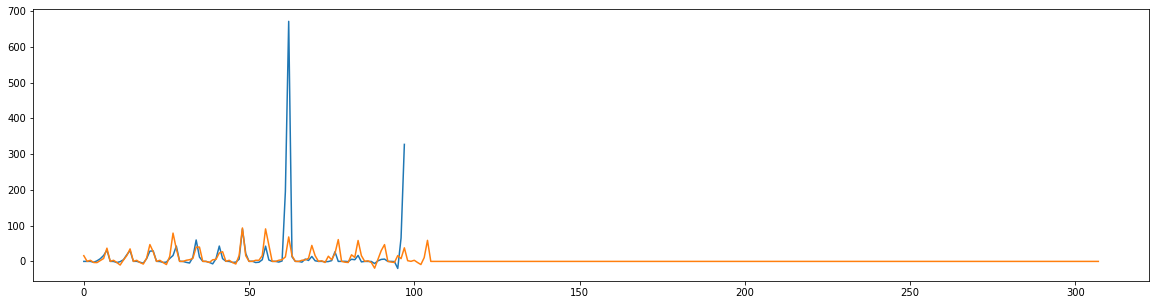

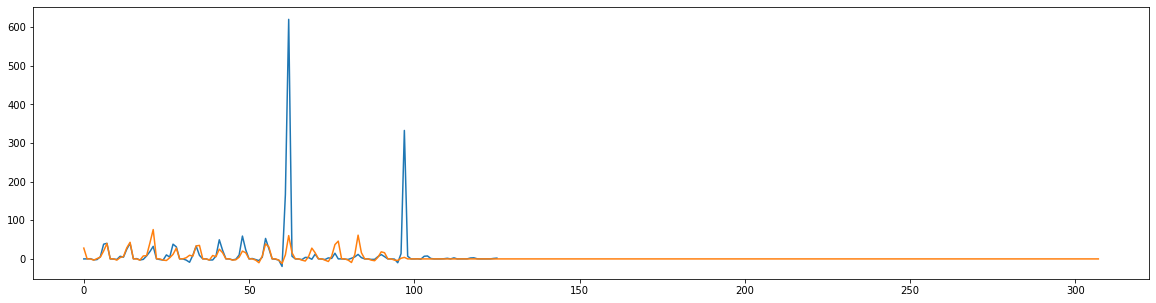

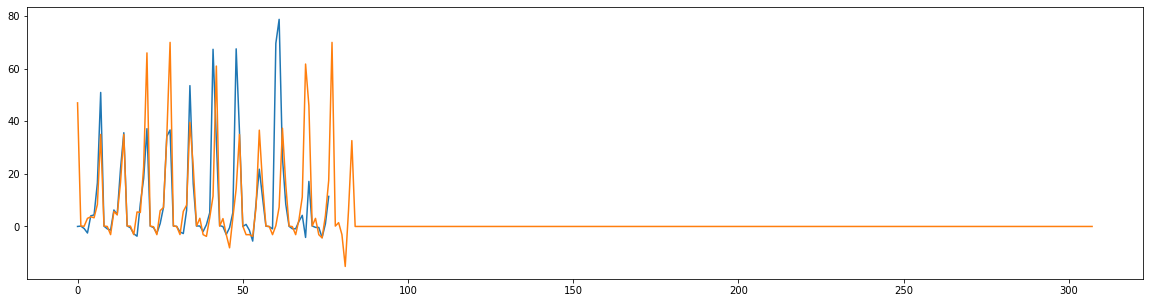

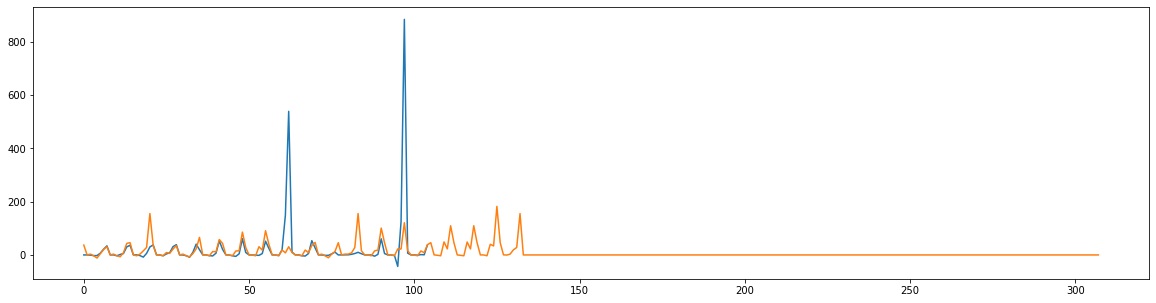

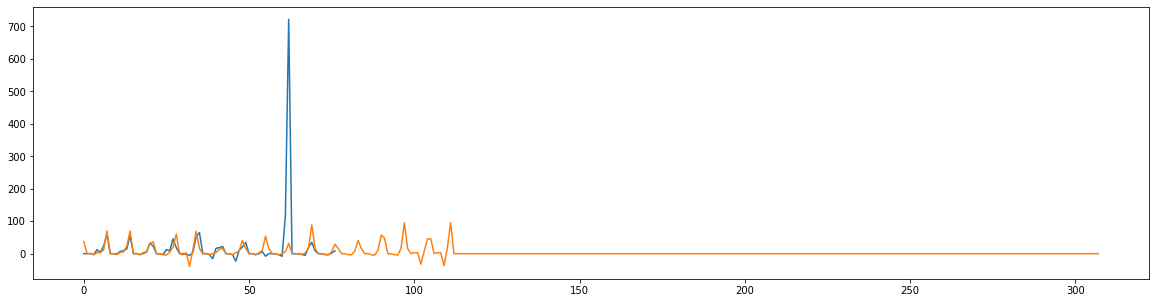

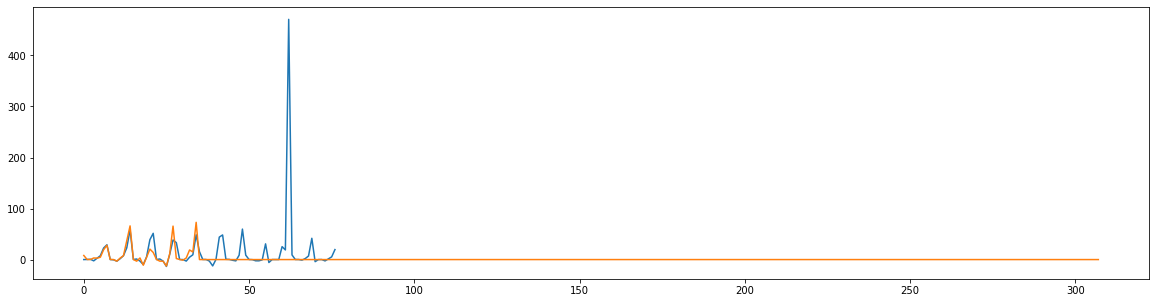

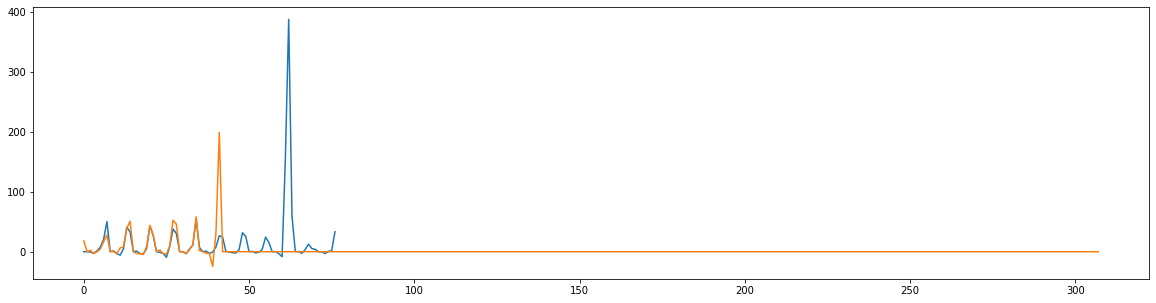

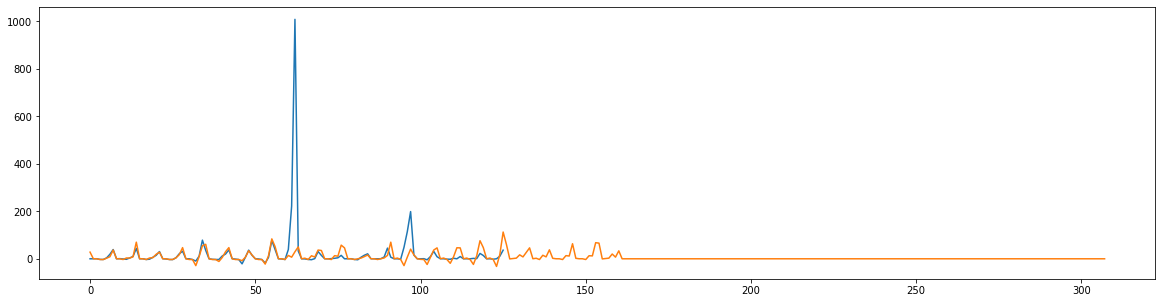

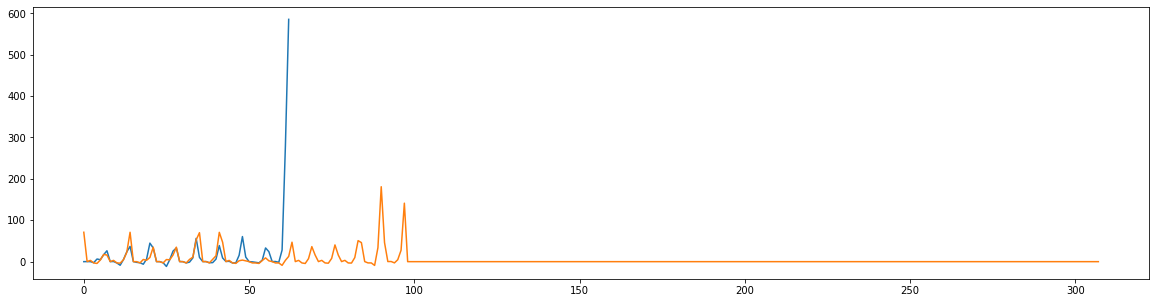

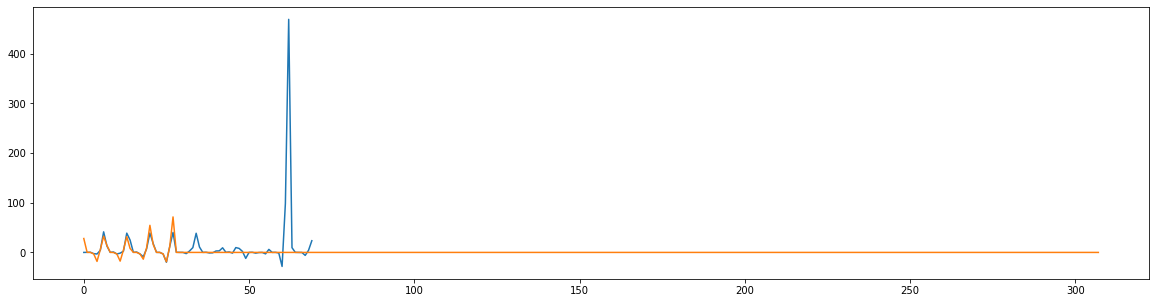

In [0]:
for i in list(range((10))):
    plt.figure(figsize=(20,5))
    plt.plot(result.iloc[i,list(range(0,308))])
    plt.plot(y_validation.iloc[i,list(range(0,308))])
    plt.show()

In [0]:
result['PredictionString'] = [str(list(result.loc[i,list(range(0,308))])).replace(',', '').replace('[', '').replace(']', '').replace(' nan', '') for i in list(result.index)]
result['PredictionString'] = result['PredictionString'].astype('str')

In [0]:
result.index

Int64Index([3693,  896,  517, 2434, 1953, 1478, 3410,  774, 3859, 2390,
            ...
             755, 2853, 3952, 2187, 3454, 3646,  512, 1251, 2535,  997],
           dtype='int64', length=170)

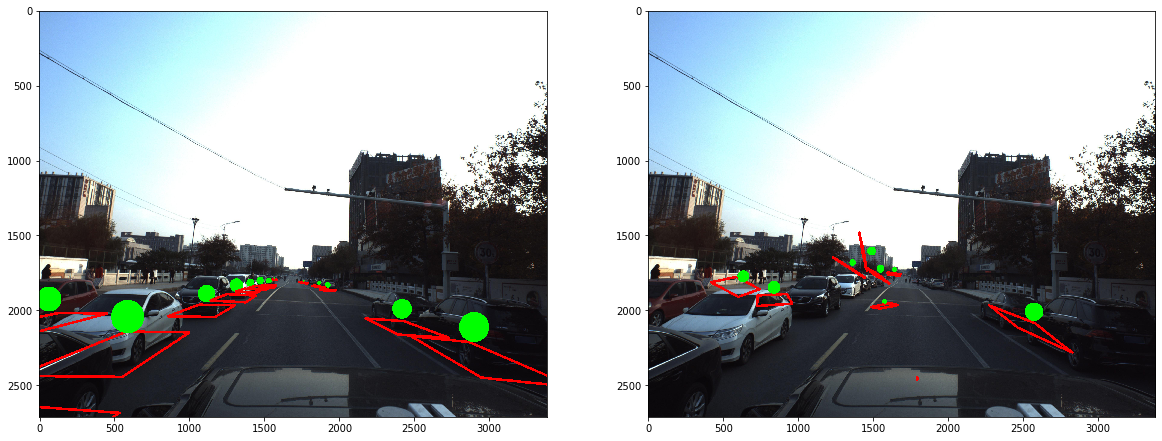

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20,20))
img = imread('Data/' + 'train_images/' + train['ImageId'].loc[3859] + '.jpg')
img_vis = visualize(img, str2coords(train['PredictionString'].loc[3859]))
axes[0].imshow(img_vis)
img_vis = visualize(img, str2coords(result['PredictionString'].loc[3859]))
axes[1].imshow(img_vis)
plt.show()

# Deployement

In [0]:
test_img_df

test_img       ImageId
0     Data/Final/ID_1041a3f4d.jpg  ID_1041a3f4d
1     Data/Final/ID_4331e8c9e.jpg  ID_4331e8c9e
2     Data/Final/ID_6c14e293e.jpg  ID_6c14e293e
3     Data/Final/ID_6a41db187.jpg  ID_6a41db187
4     Data/Final/ID_7c282ea36.jpg  ID_7c282ea36
...                           ...           ...
2016  Data/Final/ID_62f6ee599.jpg  ID_62f6ee599
2017  Data/Final/ID_2d2c3fe25.jpg  ID_2d2c3fe25
2018  Data/Final/ID_301ebfbd6.jpg  ID_301ebfbd6
2019  Data/Final/ID_0b595ee86.jpg  ID_0b595ee86
2020  Data/Final/ID_b753e614d.jpg  ID_b753e614d

[2021 rows x 2 columns]

In [0]:
# Test
def image_format_test(i, border, size):
    image1 = Image.open(test['test_img'][i])
    image1 = ImageOps.expand(image1, border=border, fill=0)
    x = np.array(image1).shape[0]
    y = np.array(image1).shape[1]
    image1 = ImageOps.fit(image1, (max(x, y),max(x, y)),2, 0.0,(0.5,0.5))
    image1 = image1.resize((size, size), resample=0)
    return image1

shutil.rmtree('Data/Final', True)
# On crée les dossiers d'entrainement
create_repertory('Data/Final')
test = pd.DataFrame(test_img_df)
for k in list(test.index):
    img = image_format_test(k, 0, 512)
    img = img.save('Data/Final/' + test['ImageId'][k] + '.jpg')
    print(test['ImageId'][k])
test['test_img'] = test['test_img'].str.replace('test_images', 'Final')

ID_1041a3f4d
ID_4331e8c9e
ID_6c14e293e
ID_6a41db187
ID_7c282ea36
ID_fceae5248
ID_5a9ecd61c
ID_43b9f671e
ID_826d8a694
ID_84323688f
ID_e6a0c4b92
ID_68c414f42
ID_f0281c7d6
ID_924880548
ID_b4803dad5
ID_fb66fca19
ID_08b7d6f4a
ID_ce57b1aee
ID_5b68ced35
ID_988130347
ID_4f6fbc500
ID_429b79cb8
ID_8a46d4ff9
ID_60c3db66f
ID_e88770830
ID_7a930c15c
ID_2544adab9
ID_0a5908893
ID_322087612
ID_1b51359a6
ID_dc0112c8d
ID_38ea118eb
ID_0d5fe2dbb
ID_1617b5747
ID_34da5bfe3
ID_16976e01a
ID_31774a362
ID_a89da0155
ID_9f7e82ce3
ID_67d5d5b3d
ID_984c81491
ID_ccec471ef
ID_0513c5eb7
ID_da31d59d1
ID_55e70f7c8
ID_ce85778b4
ID_10bb22dd9
ID_1471e5b4e
ID_09d9753f2
ID_310b9f145
ID_9a340aeb8
ID_671a0460f
ID_d959d6a90
ID_fae5de180
ID_a6ed522c4
ID_e95c604f2
ID_be77fd64f
ID_0e94bf0f1
ID_7579cd29a
ID_9a0af2430
ID_f83fe5925
ID_137eceb83
ID_4dfabddb8
ID_08fe37c81
ID_e3da9a6a0
ID_38aaf4faa
ID_bbe017172
ID_911b03510
ID_b832b9342
ID_3ba7e9f78
ID_949329d01
ID_0f1f9d5e4
ID_b0f19bb62
ID_4445bb25a
ID_01e6e5f61
ID_20a0d9759
ID_8c41d998f

In [0]:
# On applique les modèles
model_name = 'nb_car.h5'
first_model.load_weights('/content/' + model_name)
# import val
y_hat_total = []
for i in list(range(test['test_img'].shape[0])):
    print(test['ImageId'][i])
    test_image = Image.open(test['test_img'][i])
    test_image_full = np.array(test_image)
    test_image = test_image.resize((512, 512), resample=0)
    test_image = np.array(test_image)/255
    test_image = np.expand_dims(test_image, axis=0)
    result = int(first_model.predict(test_image)*44)
    y_hat = []
    for i in list(range(1,141)):
        if i <= (7*result-1):    
            model_name = 'model' + str(i) + '.h5'
            train_model.load_weights('/content/' + model_name)
            result2 = train_model.predict(test_image)
            y_hat.append(result2[0][0])
        else:
            y_hat.append(None)
    y_hat_total.append(y_hat)


ID_1041a3f4d
ID_4331e8c9e
ID_6c14e293e
ID_6a41db187
ID_7c282ea36
ID_fceae5248
ID_5a9ecd61c
ID_43b9f671e
ID_826d8a694
ID_84323688f
ID_e6a0c4b92
ID_68c414f42
ID_f0281c7d6
ID_924880548
ID_b4803dad5
ID_fb66fca19
ID_08b7d6f4a
ID_ce57b1aee
ID_5b68ced35
ID_988130347
ID_4f6fbc500
ID_429b79cb8
ID_8a46d4ff9
ID_60c3db66f
ID_e88770830
ID_7a930c15c
ID_2544adab9
ID_0a5908893
ID_322087612
ID_1b51359a6
ID_dc0112c8d
ID_38ea118eb
ID_0d5fe2dbb
ID_1617b5747
ID_34da5bfe3
ID_16976e01a
ID_31774a362
ID_a89da0155
ID_9f7e82ce3
ID_67d5d5b3d
ID_984c81491
ID_ccec471ef
ID_0513c5eb7
ID_da31d59d1
ID_55e70f7c8
ID_ce85778b4
ID_10bb22dd9
ID_1471e5b4e
ID_09d9753f2
ID_310b9f145
ID_9a340aeb8
ID_671a0460f
ID_d959d6a90
ID_fae5de180
ID_a6ed522c4
ID_e95c604f2
ID_be77fd64f
ID_0e94bf0f1
ID_7579cd29a
ID_9a0af2430
ID_f83fe5925
ID_137eceb83
ID_4dfabddb8
ID_08fe37c81
ID_e3da9a6a0
ID_38aaf4faa
ID_bbe017172
ID_911b03510
ID_b832b9342
ID_3ba7e9f78
ID_949329d01
ID_0f1f9d5e4
ID_b0f19bb62
ID_4445bb25a
ID_01e6e5f61
ID_20a0d9759
ID_8c41d998f

ValueError: ignored

In [0]:
# Result preparation
result = pd.DataFrame(y_hat_total, columns=list(range(1,141)))
for i in list(range(141,308)):
    result[i] = None
result[0] = 0
result = result[list(range(0, 308))].astype('float32')
for i in list(range(0, 308)):
    for j in list(result.index):
        if result.loc[j, i] is not None:
            if result.loc[j, i] > 1:
                result.loc[j, i] = 1
            elif result.loc[j, i] < -1:
                result.loc[j, i] = -1
result = result*normalize_max
result[308] = None
for i in list(result.index):
    for j in list(range(7,309,7)):
        if math.isnan(result.loc[i,j-1]):
            result.loc[i,j] = None
        else:
            result.loc[i,j] = 0.1
result = result[list(range(0, 309))].astype('float32')
result['PredictionString'] = [str(list(result.loc[i,list(range(1, 309))])).replace(',', '').replace('[', '').replace(']', '').replace(' nan', '').replace('nan', '') for i in list(result.index)]
result['PredictionString'] = result['PredictionString'].astype('str')
result_for_validation = pd.DataFrame({'ImageId' : list(test['ImageId']), 'PredictionString' : list(result['PredictionString'])})

In [0]:
sample_submission = pd.read_csv('sample_submission.csv')
submission = pd.merge(sample_submission[['ImageId']], result_for_validation, on='ImageId')
submission.to_csv('submission.csv', sep=',', index=False)

# Autres test de modèles non concluants

In [0]:
#@title Transfert Learning modèle trop lourd
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import inception_resnet_v2
from keras.optimizers import RMSprop

#On initialise
new_model = Sequential()
# On ajoute le modèle préentriné
new_model.add(InceptionResNetV2(include_top=False, weights='imagenet', input_shape = (512, 512, 3)))
# On précise que les layers qui ne seront pas entrainé
for layer in new_model.layers:
    layer.trainable = False
# Couche Flattening
new_model.add(Flatten())


# Couche Fully connected
for i in list(range(1)):
    # Réseau de neurone
    new_model.add(Dense(units=1024, activation="relu"))
# Réseau de neurone
new_model.add(Dense(units=1,
                    activation="linear"))

new_model.compile(optimizer='Adam', loss=sum_absolute_error, metrics=[score])
checkpoint = ModelCheckpoint("transfer_learning_inception_resnet_v2.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)


new_model.summary()
datagen = ImageDataGenerator(preprocessing_function=inception_resnet_v2.preprocess_input)

training_set = datagen.flow_from_dataframe(new_train,
                                                 directory=None,
                                                 x_col='x',
                                                 y_col='nb_car',
                                                 weight_col=None,
                                                 target_size=(512, 512),
                                                 color_mode='rgb',
                                                 classes=None,
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=None,
                                                 save_to_dir=None,
                                                 save_prefix='',
                                                 save_format='jpg',
                                                 subset=None,
                                                 interpolation='nearest', 
                                                 validate_filenames=True)

test_set = datagen.flow_from_dataframe(new_test,
                                            directory=None,
                                            x_col='x',
                                            y_col='nb_car',
                                            weight_col=None,
                                            target_size=(512, 512),
                                            color_mode='rgb',
                                            classes=None,
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix='',
                                            save_format='jpg',
                                            subset=None,
                                            interpolation='nearest', 
                                            validate_filenames=True)

val_set = datagen.flow_from_dataframe(new_val,
                                            directory=None,
                                            x_col='x',
                                            y_col='nb_car',
                                            weight_col=None,
                                            target_size=(512, 512),
                                            color_mode='rgb',
                                            classes=None,
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix='',
                                            save_format='jpg',
                                            subset=None,
                                            interpolation='nearest', 
                                            validate_filenames=True)

History = new_model.fit_generator(training_set,
                        steps_per_epoch=int(math.ceil(len(training_set.filenames)/32)), # len du jeux d'entrainement / batch
                        epochs=50,
                        validation_data=test_set,
                        validation_steps=int(math.ceil(len(test_set.filenames)/32)),
                        callbacks = [checkpoint],
                        workers=4)

plt.figure(figsize=(30,10))
y_hat = []
for i in list(range(len(val_set.filepaths))):
    test_image = Image.open(val_set.filepaths[i])
    test_image_full = np.array(test_image)
    test_image = test_image.resize((512, 512), resample=0)
    test_image = np.array(test_image)/255
    test_image = np.expand_dims(test_image, axis=0)
    result = first_model.predict(test_image)
    y_hat.append(int(result[0]*44))

    
plt.plot(y_hat)
plt.plot(list(liste['nb_car'][liste_index_val]))
ecart = np.mean(np.abs(np.array(y_hat) - liste['nb_car'][liste_index_val]))
print('mean absolute error: ', ecart)